In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from numba import jit

import matplotlib.pyplot as plt
from zigzag import *
import datetime

In [6]:
from tqsdk.ta import MA, EMA

在使用天勤量化之前，默认您已经知晓并同意以下免责条款，如果不同意请立即停止使用：https://www.shinnytech.com/blog/disclaimer/
TqSdk 发布了 3.3.0(2022/11/22) 版本，支持广州期货交易所 GFEX，如果用户需要交易广期所合约需要升级到此版本以上。
更新说明链接：https://doc.shinnytech.com/tqsdk/latest/version.html


In [7]:
from tqsdk.tafunc import ma, ema, abs, std, hhv, llv, count, time_to_datetime, barlast

In [86]:
from numpy import nan_to_num

# Functions

## get_long_orders

In [8]:
def get_long_orders(rb_df):
# long only
    rb_df['orders'] = 0
    position = 0
    for k in range(len(rb_df)):
        if rb_df.LONG[k]==1 and position == 0 :
            rb_df.orders.values[k] = 1
            position = 1
        elif position == 1  and rb_df.S_LONG[k]==1:
            rb_df.orders.values[k] = -1
            position = 0
    return rb_df

## get_short_orders

## backtest_long

In [9]:
def backtest_long(rb_df,init_cash):
    positions = pd.DataFrame(index = rb_df.index)
    portfolio = pd.DataFrame(index = rb_df.index)
    positions['stock'] = 4*rb_df['orders'].cumsum()
    # portfolio = positions.multiply(rb_df['close'],axis=0)
    portfolio['holding_values'] = positions.multiply(rb_df['close'],axis=0)
    pos_diff = positions.diff()
    portfolio['cash'] = init_cash - (pos_diff.multiply(rb_df['close'],axis=0)).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holding_values']
    portfolio['orders'] = rb_df['orders']
    portfolio['price']=rb_df.orders.diff()*rb_df.close
    return portfolio

In [10]:
# rb_df.orders.diff()*rb_df.close

## backtest_short

In [11]:
def backtest_short(rb_df,init_cash):
#     initial_cash = 20000
    positions = pd.DataFrame(index = rb_df.index)
    portfolio = pd.DataFrame(index = rb_df.index)
    positions['stock'] = 4*rb_df['orders'].cumsum()
    # portfolio = positions.multiply(rb_df['close'],axis=0)
    portfolio['holding_values'] = positions.multiply(rb_df['close'],axis=0)
    pos_diff = positions.diff()

    portfolio['cash'] = init_cash + (pos_diff.multiply(rb_df['close'],axis=0)).cumsum()
    portfolio['total'] = portfolio['cash'] - portfolio['holding_values']
    return portfolio


## get_trading_summary

In [12]:
def get_trading_summary(portfolio):
    df_only_orders = portfolio.query("orders in (1,-1)") 
    df_only_orders.loc[:,('lag_total')] = df_only_orders.total.shift(1)
    df_only_orders.loc[:,('lead_total')] = df_only_orders.total.shift(-1)
    df_only_orders.loc[:,('pro_loss')] = df_only_orders\
        .apply(lambda x:x.lead_total - x.total if x.orders==1 else  x.total -x.lag_total,axis=1)
    df_only_orders.loc[:,('date')] = df_only_orders.index.map(lambda x:x[:10])
    return df_only_orders.filter(['pro_loss','orders','price','date'])

## get_win_loss_ration

In [13]:
def get_win_loss_ration(trade_summary):
    df_win = trade_summary.query('pro_loss > 0 and orders == 1')
    df_loss = trade_summary.query('pro_loss < 0 and orders == 1')
    win_avg = df_win.pro_loss.mean()
    loss_avg = df_loss.pro_loss.mean()
    return {'win_avg':win_avg,'loss_avg':loss_avg,'ratio':win_avg/loss_avg}

## get_top1_vol

In [14]:
def get_top1_vol(df):
    return df.

SyntaxError: invalid syntax (<ipython-input-14-f5431803eaba>, line 2)

## get_top2_vol

## get_top3_vol

## get_ma_stage pandas

In [15]:
def get_ma_stage(kline):
    if (kline.dtxt & (kline.mslp1s >= 1000) & (kline.bias1 >= 1)):
        return 'dtjg'  # 多头进攻
    elif kline.dtxt & (kline.mslp1s < 1000) & (kline.bias1 > 1):
        return 'dttz'  # 多头调整
    elif kline.dtxt & (kline.bias4 >= -0.5) & (kline.bias4 <= 1):
        return 'cai_ma4'  # 踩ma4
    elif kline.dtxt & (kline.bias3 >= -0.5) & (kline.bias3 <= 1):
        return 'cai_ma3'  # 踩ma3
    elif kline.dtxt & (kline.bias2 >= -0.5) & (kline.bias2 <= 1):
        return 'cai_ma2'  # 踩ma2
    elif kline.dtxt & (kline.bias1 >= -0.5) & (kline.bias1 <= 1):
        return 'cai_ma1'  # 踩ma1
    elif kline.dtxt & (kline.bias3 <= -0.5) & (kline.bias4 >= 1):
        return 'dzj34'  # 多中继34
    elif kline.dtxt & (kline.bias2 <= -0.5) & (kline.bias3 >= 1):
        return 'dzj23'  # 多中继23
    elif kline.dtxt & (kline.bias1 <= -0.5) & (kline.bias2 >= 1):
        return 'dzj12'  # 多中继12
    elif kline.dtxt & (kline.bias4 <= -0.5):
        return 'oversell'
    elif kline.ktxt & (kline.mslp1s <= 1000) & (kline.bias1 < -1):
        return 'ktjg'  # 空头进攻
    elif kline.ktxt & (kline.mslp1s > 1000) & (kline.bias1 < -1):
        return 'kttz'  # 空头调整
    elif kline.ktxt & (kline.bias4 <= 0.5) & (kline.bias4 >= -1):
        return 'chou_ma4'  # 抽ma4
    elif kline.ktxt & (kline.bias3 <= 0.5) & (kline.bias3 >= -1):
        return 'chou_ma3'  # 抽ma3
    elif kline.ktxt & (kline.bias2 <= 0.5) & (kline.bias2 >= -1):
        return 'chou_ma2'  # 抽ma2
    elif kline.ktxt & (kline.bias1 <= 0.5) & (kline.bias1 >= -1):
        return 'chou_ma1'  # 抽ma1
    elif kline.ktxt & (kline.bias3 >= 0.5) & (kline.bias4 <= -1):
        return 'kzj34'  # 空中继34
    elif kline.ktxt & (kline.bias2 >= 0.5) & (kline.bias3 <= -1):
        return 'kzj23'  # 空中继23
    elif kline.ktxt & (kline.bias1 >= 0.5) & (kline.bias2 <= -1):
        return 'kzj12'  # 空中继12
    elif kline.ktxt & (kline.bias4 >= 0.5):
        return 'overbuy'
    else:
        return 'others'


## get_price_pos

combined into get_price_stage

In [16]:
def get_price_pos(base):
#     baseC = base.copy()
#     for i in range(base.shape[1]):
#         baseC.iloc[:,i] = abs(base.iloc[:,i])
#     return np.argmin(baseC.values,axis=1)+1
    return np.abs(base.values).argmin(axis=1) + 1

## get_min_bias

combined into get_price_stage

In [17]:
def get_min_bias(base):
    x = base.values
#     x = base.copy()
#     index = base.iloc[:,-1:].copy()
    return x[np.arange(len(x)), np.abs(x).argmin(axis=1)]

In [18]:
# def get_price_stage(base):
#     if (abs(base.min_bias) < 0.5):
#         return 'cai_ma' 
# #     + str(base.price_pos)
# #     elif base.min_bias > 0.5:
# #         return 'dt_pos'
# #     elif base.min_bias <-0.5:
# #         return 'kt_pos'
#     else:
#         return 'others'
#     return 'cai' if (abs(base.min_bias) < 0.5) else 'others'
#     return abs(base.min_bias) < 0.5

# Numpy Functions

## rolling_window

In [19]:
def rolling_window(a,window):
    shape = a.shape[:-1] + (a.shape[-1] - window +1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [20]:
# data = np.arange(20)
# rolling_window(data,10).max(1)

## zig

In [21]:
# ZIG_STATE_START = 0
# ZIG_STATE_RISE = 1
# ZIG_STATE_FALL = 2

# def zig(x=0.055):
# #ts.set_token("此处放入tushare的token！！！")
# #pro = ts.pro_api()
# #df = pro.daily(ts_code="603297.SH")
# # print(list(df["close"]))
# # df = ts.get_hist_data(‘000069‘)
# # df = df[::-1]
# # 获取股票交易数据的Tushare的使用方法 - 蜗牛爬行ing - 博客园
# # https://www.cnblogs.com/DreamRJF/p/8660630.html
# # posted on 2018-03-28 15:18 蜗牛爬行ing
# #df = ts.get_k_data(‘000069‘)
# # df = ts.get_k_data(‘600535‘)
# # df = ts.get_k_data(‘512040‘) # 富国国信价值 etf 基金
# # df = ts.get_h_data(‘000051‘, index=True) # 上证180等权指数 index 参数必须指定为True

# df = ts.get_k_data(‘000051‘, index=True, start=‘2011-01-01‘) # 上证180等权指数 index 参数必须指定为True

# #df = ts.get_h_data(‘399106‘, index=True) # index 参数必须指定为True
# #df = ts.get_h_data(‘399106‘, index=True) #深圳综合指数
# #df = ts.get_k_data(‘399106‘, index=True) #深圳综合指数
# # df = ts.get_k_data(‘931052‘, index=True) # 中证国信价值指数， 不支持的指数
# # df = ts.get_k_data(‘hs300‘) # 支持主要的几个股票指数的历史行情
# # 股票代码，即6位数字代码，或者指数代码
# # (sh=上证指数 sz=深圳成指 hs300=沪深300指数
# # sz50=上证50 zxb=中小板 cyb=创业板)
# #df = df.reset_index(drop=True)
# # df = df.iloc[-100:]
# #x = 0.055

# k = df["close"]

# #d = df["trade_date"]

# d = df[‘date‘]

# # d = df.index

# #print(k)

# #print(d)

# # 循环前的变量初始化

# # 端点 候选点 扫描点 端点列表 拐点线列表 趋势状态

# peer_i = 0
# candidate_i = None
# scan_i = 0
# peers = [0]
# z = np.zeros(len(k))
# state = ZIG_STATE_START
# while True:
# #print(peers)

# scan_i += 1
# if scan_i == len(k) - 1:

# # 扫描到尾部
# if candidate_i is None:
# peer_i = scan_i
# peers.append(peer_i)

# else:

# if state == ZIG_STATE_RISE:
# if k[scan_i] >= k[candidate_i]:
    
# peer_i = scan_i
# peers.append(peer_i)

# else:

# peer_i = candidate_i
# peers.append(peer_i)
# peer_i = scan_i
# peers.append(peer_i)

# elif state == ZIG_STATE_FALL:
# if k[scan_i] <= k[candidate_i]:

# peer_i = scan_i
# peers.append(peer_i)

# else:

# peer_i = candidate_i
# peers.append(peer_i)
# peer_i = scan_i
# peers.append(peer_i)

# break

# if state == ZIG_STATE_START:
# if k[scan_i] >= k[peer_i] * (1 + x):

# candidate_i = scan_i
# state = ZIG_STATE_RISE

# elif k[scan_i] <= k[peer_i] * (1 - x):
# candidate_i = scan_i
# state = ZIG_STATE_FALL

# elif state == ZIG_STATE_RISE:
# if k[scan_i] >= k[candidate_i]:

# candidate_i = scan_i
# elif k[scan_i] <= k[candidate_i]*(1-x):

# peer_i = candidate_i
# peers.append(peer_i)
# state = ZIG_STATE_FALL
# candidate_i = scan_i

# elif state == ZIG_STATE_FALL:

# if k[scan_i] <= k[candidate_i]:
#     candidate_i = scan_i

# elif k[scan_i] >= k[candidate_i]*(1+x):
#     peer_i = candidate_i
#     peers.append(peer_i)
#     state = ZIG_STATE_RISE
#     candidate_i = scan_i

# #线性插值， 计算出zig的值

# for i in range(len(peers) - 1):
#     peer_start_i = peers[i]
#     peer_end_i = peers[i+1]
#     start_value = k[peer_start_i]
#     end_value = k[peer_end_i]

# a = (end_value - start_value)/(peer_end_i - peer_start_i)# 斜率
# for j in range(peer_end_i - peer_start_i +1):

# z[j + peer_start_i] = start_value + a*j
# print(u‘...转向点的阀值、个数、位置和日期...‘)

# print(x, len(peers))
# print(peers)

# dates = [d[i] for i in peers]
# print(dates)

# #print([k[i] for i in peers])
# #print(list(k))
# #print(list(z))

# plt.plot(z)

# zig(x=0.055)


## get_price_stage

In [555]:
def get_price_stage(bias,df_ma):
    ma_cnt = bias.shape[1]
    if (s3==m1) & (m3==l1) & (ma_cnt==7):
        col_indx=[0,1,2,4,5,7,8]
#         arr_bias=bias.values[:,[0,1,2,4,5,7,8]]
        arr_bias=bias.values
#         arr_df_ma=df_ma.values[:,[0,1,3,4,6,7]]
        arr_df_ma=df_ma.values
    elif (s3==m1) and (m3!=l1) & (ma_cnt==8):
        col_indx=[0,1,2,4,5,6,7,8]
        arr_bias=bias.values[:,[0,1,2,4,5,6,7,8]]
        arr_df_ma=df_ma.values[:,[0,1,3,4,5,6,7]]     
    elif (s3!=m1) and (m3==l1) & (ma_cnt==8):
        col_indx=[0,1,2,3,4,5,7,8]
        arr_bias=bias.values[:,[0,1,2,3,4,5,7,8]]
        arr_df_ma=df_ma.values[:,[0,1,2,3,4,6,7]]  
    else:
        col_indx=[0,1,2,3,4,5,6,7,8]
        arr_bias=bias.values[:,[0,1,2,3,4,5,6,7,8]]
        arr_df_ma=df_ma.values[:,[0,1,2,3,4,5,6,7]] 
#    arr_2_df_ma=arr_df_ma[:2]
#    arr_3_df_ma=arr_df_ma[:3]  
    ll=list(range(1,arr_bias.shape[1]))
    ll.extend([0])
    arr_bias2=arr_bias[:,ll]
    arr_comb= np.absolute(arr_bias)+np.absolute(arr_bias2) # 获得相邻df_ma的sum
    df_ma_abs = np.absolute(arr_df_ma)
    check = np.round((arr_comb[:,:-1] - df_ma_abs),decimals=2) #相邻df_ma的sum - df，为0的则表示价格在着2条ma之间
    b = np.array(np.where(check == 0)) # 找到价格所在的位置
    a = np.transpose(b)
    
    overlap_count=np.unique(a[:, 0], return_counts=True) #找到价格在ma中间的个数
    overlap_list=np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:]) #列出所有  价格在ma的位置
    
    idx_overlap=overlap_count[0] #index_data
    index=np.arange(bias.shape[0])
    index.shape=(bias.shape[0],1) #创建和外部df一样的dim
    obj_arr=np.empty((bias.shape[0],1), dtype=object) #创建obj array来存arr 价格所在的ma位置  如果
    obj_arr_2d=np.hstack((index,obj_arr)) #
    ## 赋值 价格在ma的所有位置
    obj_arr_2d[idx_overlap.tolist(),1]=overlap_list 
    temp=np.zeros(bias.shape[0])
    temp.shape=(bias.shape[0],1)
    temp1=np.hstack((obj_arr_2d,temp))
    temp1[idx_overlap.tolist(),2]=overlap_count[1]  #数据对应的index
    idx_above_ma = (bias>0).all(axis=1)
    idx_below_ma = (bias<0).all(axis=1)
    temp1[idx_above_ma,2]=99
    temp1[idx_below_ma,2]=-99
    out_ma_ind=temp1[temp1[:,2] == 0] # 找到arr无值的
    price_pos=np.abs(bias.values).argmin(axis=1) #获取最小bias的位置
    min_bias=arr_bias[np.arange(bias.shape[0]), np.abs(arr_bias).argmin(axis=1)] #获取最小bias值
    return np.column_stack((temp1, price_pos, min_bias))[:,1:]
#     return arr_bias

In [556]:
(bias<0).all(axis=1)

0       False
1        True
2       False
3        True
4       False
        ...  
8395    False
8396    False
8397    False
8398    False
8399    False
Length: 8400, dtype: bool

In [543]:
bias<0

,bias1,bias2,bias3,bias4,bias5,bias6,bias7
0,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True
2,False,True,True,True,True,True,True
3,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
8395,False,False,False,False,False,False,False
8396,False,False,False,False,False,False,False
8397,False,False,False,False,False,False,False
8398,False,False,False,False,False,False,False


In [1012]:
c=overlap_count[0]
index=np.arange(bias.shape[0])
index.shape=(bias.shape[0],1)
obj_arr=new = np.empty((bias.shape[0],1), dtype=object)
obj_arr_2d=np.hstack((index,obj_arr)
obj_arr_2d[c.tolist(),1]=d

In [1007]:
[col_indx[c[i]]  for i in list(range(c.shape[0]))]

[0,
 1,
 2,
 4,
 5,
 7,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 4,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 5,
 5,
 0,
 4,
 0,
 4,
 5,
 5,
 5,
 5,
 0,
 4,
 5,
 5,
 5,
 0,
 5,
 5,
 0,
 5,
 1,
 4,
 1,
 4,
 5,
 2,
 4,
 4,
 5,
 2,
 4,
 0,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 0,
 4,
 4,
 5,
 5,
 5,
 5,
 7,
 7,
 7,
 7,
 7,
 0,
 7,
 1,
 5,
 0,
 7,
 7,
 7,
 1,
 7,
 2,
 5,
 0,
 0,
 0,
 5,
 1,
 2,
 4,
 5,
 5,
 0,
 1,
 4,
 5,
 2,
 5,
 5,
 7,
 7,
 7,
 5,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 4,
 0,
 4,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 4,
 4,
 4,
 2,
 4,
 5,
 4,
 4,
 5,
 5,
 0,
 4,
 0,
 4,
 1,
 4,
 1,
 4,
 0,
 4,
 1,
 4,
 4,
 4,
 4,
 5,
 4,
 0,
 0,


In [131]:
tt=get_price_stage(bias,df_ma)

## get_pct_freq

In [28]:
def get_pct_freq(pct_data,n,bin):
    col=15
    res=np.arange(col*8400)
# col 0 index，col 1开始存数据 1-10列用来存bin范围的值  
#     1-2 极端和异常下跌 3，4，5 大中小跌
#     6，7为震荡
#    8，9，10为小中大涨，11，12为异常和极端上涨 
#    13 存十字星  14列存震荡
    res.shape=(col,8400)
    res=res.T
    ll=len(bin)
    res[:,1:]=0
    for i in list(range(ll+1)):
        if i == 0:
#             col 1开始存数据
            res[:,i+1]=np.nan_to_num(count(pct_data<bin[i],n).values,nan=0)
        elif i==11:
            res[:,i+1]=np.nan_to_num(count(bin[i-1]<=pct_data,n).values,nan=0)
        else:
            res[:,i+1]=np.nan_to_num(count((bin[i-1] <= pct_data) & (pct_data < bin[i]),n).values,nan=0)
     # 将十字星单独拎出来
    res[:,ll+2]=np.nan_to_num(count(0==pct_data,n).values,nan=0)
    # 存震荡
    res[:,ll+3]=res[:,6] + res[:,7]
    return res

In [29]:
def get_pct_freq2(row):
    bin_idx=np.arange(12)
    nz=np.zeros(12)
    bin_base=np.vstack((bin_idx,nz)).T
    uniqueValues, occurCount = np.unique(row, return_counts=True)
#     bin_base[]
    res=np.asarray((uniqueValues, occurCount)).T
    bin_base[res[:,0].tolist(),1]=res[:,1]
    dw_part= bin_base[:6,1].sum()
    dw_pct = dw_part/row.shape[0]*100
#     net_up_pct
    return dw_pct #bin_base

<function bin(number, /)>

In [24]:
# 比较耗时 300多ms
# [get_pct_freq(dd[i,:]) for i in list(range((dd.shape[0])))]

In [25]:
bin_arr=np.vstack((np.arange(len(bin)),bin)).T

TypeError: object of type 'builtin_function_or_method' has no len()

In [108]:
pct_data=base.pct_chg
res = get_pct_freq(pct_data,10,bin)

In [107]:
bin

[-20, -5, -3, -1.9, -0.8, 0, 0.8, 1.9, 3, 5, 20]

## get_pct_stage

In [30]:
def get_pct_stage(res):
# col 0 index，col 1开始存数据 1-10列用来存bin范围的值  
#     1-2 极端和异常下跌 3，4，5 大中小跌
#     6，7为震荡
#    8，9，10为小中大涨，11，12为异常和极端上涨 
#    13 存十字星  14列存震荡
    mtm=np.zeros((res.shape[0],20))
#     0-4 下跌  6-10 上涨
#    算下跌力
    mtm[:,0]=res[:,3]*2.5+res[:,4]*1.5+res[:,5]
    # 算上涨力
    mtm[:,1]=res[:,10]*2.5+res[:,9]*1.5+res[:,8]
    # 算净力
    mtm[:,2]=mtm[:,1] - mtm[:,0]
    #有波动 没有大跌 没有中跌 没有大涨 没有中涨 小涨 3
    pattern1=(mtm[:,1]>=3) & (mtm[:,2]>-2) & (mtm[:,2]<=2) & (res[:,3]==0) & (res[:,4]==0) & (res[:,10]==0) & (res[:,9]==0)
    mtm[pattern1,3]=1
    #有波动 没有大跌 没有中跌 没有大涨 中涨 1 小涨 1
    pattern2=(mtm[:,1]>=2.5) & (mtm[:,2]>-2) & (mtm[:,2]<=2) & (res[:,10]==0)  & (res[:,9]>0)
    mtm[pattern2,4]=2
    #有波动 有大涨 有中涨
    pattern3=(mtm[:,1]>=4) & (mtm[:,2]>-2) & (mtm[:,2]<=2) & (res[:,10]>0)  & (res[:,9]>0)
    mtm[pattern3,5]=3
    # 波动小 有小涨>=2 小跌=0
    pattern4=(mtm[:,1]>=2) & (mtm[:,0]==0) & (mtm[:,2]<=4) & (res[:,10]==0)  & (res[:,9]==0)
    mtm[pattern4,6]=4
    # 大阳后小波动
    
    
    return mtm
# 11 十字星    
# 10[inf,20)  极端波动
# 9 [20,5) 异常波动
# 8 [5,3) 大阳
# 7 [3,1.8]  中涨
# 6 [1.8,0.8]  小涨
# 5 [0.8,-0.8] 震荡
# 4 [-0.8, -1.8] 小跌
# 3 [-1.8, -3] 中跌
# 2 [-3.-3,5] 大跌
# 1 [-5,-20] 异常
# 0[-20, -inf]   
# pct_cnt
# 10[inf,20)  极端波动
# 9 [20,5) 异常波动
# 8 [5,3) 大阳
# 7 [3,1.8]  中涨
# 6 [1.8,0.8]  小涨
# 5 [0.8,-0.8] 震荡
# 4 [-0.8, -1.8] 小跌
# 3 [-1.8, -3] 中跌
# 2 [-3.-3,5] 大跌
# 1 [-5,-20] 异常
# 0 [-20, -inf]   

In [125]:
mtm=get_pct_stage(res)

In [126]:
# i=5
[mtm[:,i].sum()/(i-2) for i in list(range(3,7))]

[408.0, 1521.0, 383.0, 92.0]

In [871]:
list(range(3,6))

[3, 4, 5]

In [814]:
mtm[(mtm[:,1]>3) & (mtm[:,2]>-1) & (mtm[:,2]<2)].shape
# .shape

(947, 3)

In [818]:
np.zeros((3,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [800]:
mtm

array([[    0,     1,     2],
       [    3,     4,     5],
       [    6,     7,     8],
       ...,
       [25191, 25192, 25193],
       [25194, 25195, 25196],
       [25197, 25198, 25199]])

In [788]:
# bin_arr

In [787]:
rng_cnt=[round(pct_cnt[:,i].sum()/840,0) for i in list(range(pct_cnt.shape[1]-1))] 
rng=['[-inf,-20)','[-20,-5)','[-5,-3)','[-3,-1.9)','[-1.9,-0.8)','[-0.8,0.8)','[0.8,1.9)','[1.9,3)','[3,5)','[5,20)','[20,inf]']
np.vstack((rng,rng_cnt)).T

array([['[-inf,-20)', '0.0'],
       ['[-20,-5)', '1.0'],
       ['[-5,-3)', '3.0'],
       ['[-3,-1.9)', '9.0'],
       ['[-1.9,-0.8)', '20.0'],
       ['[-0.8,0.8)', '21.0'],
       ['[0.8,1.9)', '20.0'],
       ['[1.9,3)', '8.0'],
       ['[3,5)', '3.0'],
       ['[5,20)', '1.0'],
       ['[20,inf]', '0.0']], dtype='<U32')

In [780]:
len(rng_cnt)
# len(rng)

11

In [778]:
list(range(1,13))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [770]:
bin

[-20, -5, -3, -1.9, -0.8, 0, 0.8, 1.9, 3, 5, 20]

In [737]:
res[:,1:12].sum()

83909

In [547]:
count((bin[i-1] <= pct_data) & (pct_data < bin[i]),n).values

array([nan, nan, nan, ...,  5.,  5.,  5.])

In [522]:
%time count((0<=base.pct_chg*10) & (base.pct_chg*10<0.8),10)

Wall time: 2 ms


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
8395    1.0
8396    1.0
8397    1.0
8398    1.0
8399    2.0
Length: 8400, dtype: float64

In [497]:
list(range((dd.shape[0])))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


## get_ma_stage

In [567]:
# 千分之1
unit=0.001
thresh1=1
thresh2=3

In [675]:
def get_ma_stage(ma_data,thresh1,thresh2):
    unit = 0.001
    res=np.zeros((ma_ratio.shape[0],20))
    小涨=1 + thresh1*unit
    大涨=1 + thresh2*unit
    小跌=1 - thresh1*unit
    大跌=1 - thresh2*unit
    ma_ratio.loc[:,['ma12_ratio','ma23_ratio','ma13_ratio']]=ma_data.values
    
# 普通上涨 进攻 ma12_ratio > ma23_ratio >1 & ma13_ratio < 1.2
    p1 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & \
               (ma_ratio.ma13_ratio < 小涨)
    res[p1,0] = 1
# 中度上涨  ma12_ratio > ma23_ratio >1 & 1.2 <= ma13_ratio & ma13_ratio < 1.5
    p2 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & \
                (小涨 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 大涨)
    res[p2,1] = 2
# 高度上涨  ma12_ratio > ma23_ratio >1 & 1.5 <= ma13_ratio
    p3 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & \
                 (大涨 <= ma_ratio.ma13_ratio)
    res[p3,2] = 3
# 普通上涨放缓 ma23_ratio > ma12_ratio > 1 & (ma13_ratio < 1.2)
    p4 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & \
                 ( ma_ratio.ma13_ratio < 小涨)
    res[p4,3] = 4
# 中度上涨放缓 ma23_ratio > ma12_ratio > 1 & (1.2 <= ma13_ratio) 
#                   & (1.2 <= ma13_ratio) &(ma13_ratio < 1.5)
    p5 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & \
                 (小涨 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 大涨)  
    res[p5,4] = 5
# 高度上涨放缓 ma23_ratio > ma12_ratio > 1 & (1.5 <= ma13_ratio) 
    p6 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & \
                (大涨 <= ma_ratio.ma13_ratio)
    res[p6,5] = 6
# 普通空头 ma12_ratio<ma23_ratio < 1
    p7 = (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio < 1) & \
                 (小跌 <= ma_ratio.ma13_ratio)
    res[p7,6] = 7
# 中度缩量 ma12_ratio<ma23_ratio < 1
    p8 = (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio < 1) & \
                 (大跌 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 小跌)
    res[p8,7] = 8
# 高度缩量 ma12_ratio<ma23_ratio < 1        
    p9 = (ma_ratio.ma12_ratio < ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio < 1) & \
                (ma_ratio.ma13_ratio < 大跌)
    res[p9,8] = 9
# 普通缩量放缓    
    p10 = (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio < 1) & \
                (小跌 <= ma_ratio.ma13_ratio)
    res[p10,9] = 10
# 中度缩量放缓  
    p11 = (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio < 1) & \
                (大跌 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 小跌)
    res[p11,10] = 11
# 高度缩量放缓
    p12 = (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio < 1) & \
                (ma_ratio.ma13_ratio < 大跌)
    res[p12,11] = 12
# 缩量进攻 
    p13 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma23_ratio < 1) & \
                (ma_ratio.ma13_ratio < 小跌)
    res[p13,12] = 13
# 反转进攻  
    p14 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma23_ratio < 1) & \
                (小跌 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 1)
    res[p14,13] = 14
# 放量进攻
    p15 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma23_ratio < 1) & \
                 (1 <= ma_ratio.ma13_ratio)
    res[p15,14] = 15
# 放量人气降低
    p16 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma12_ratio < 1) & \
                 (小涨 <= ma_ratio.ma13_ratio)
    res[p16,15] = 16
# 普通放量人气降低
    p17 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma12_ratio < 1) & \
                 (1 <= ma_ratio.ma13_ratio) &  (ma_ratio.ma13_ratio <小涨)
    res[p17,16] = 17
# 骤降人气
    p18 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma12_ratio < 1) & \
                 (ma_ratio.ma13_ratio < 1)  
    res[p18,17] = 18
    res[:,18] = res[:,:18].sum(axis=1)
    res[1:,19] = res[0:-1,18]
    return res    

In [649]:
ma_ratio=base[['ma12_ratio','ma23_ratio','ma13_ratio']]

In [422]:
小涨=1 + 1*unit
大涨=1 + 3*unit
小跌=1 - 1*unit
大跌=1 - 3*unit

In [ ]:
res = get_ma_stage(ma_data,thresh1,thresh2)

In [657]:
ma_data = base[['ma12_ratio','ma23_ratio','ma13_ratio']]
#     klinesC['ma_stage_m'] = get_ma_stage(klinesC[['ma34_ratio','ma45_ratio','ma35_ratio']],1,3)[:,18]
#     klinesC['ma_stage_l'] = get_ma_stage(klinesC[['ma56_ratio','ma67_ratio','ma57_ratio']],1,3)[:,18]

In [665]:
    ma_ratio.loc[:,['ma12_ratio','ma23_ratio','ma13_ratio']]=ma_data.values
    res=np.zeros((ma_ratio.shape[0],20))
# 普通上涨 进攻 ma12_ratio > ma23_ratio >1 & ma13_ratio < 1.2
    p1 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & \
               (ma_ratio.ma13_ratio < 小涨)
    res[p1,0] = 1
# 中度上涨  ma12_ratio > ma23_ratio >1 & 1.2 <= ma13_ratio & ma13_ratio < 1.5
    p2 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & \
                (小涨 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 大涨)
    res[p2,1] = 2
# 高度上涨  ma12_ratio > ma23_ratio >1 & 1.5 <= ma13_ratio
    p3 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & \
                 (大涨 <= ma_ratio.ma13_ratio)
    res[p3,2] = 3
# 普通上涨放缓 ma23_ratio > ma12_ratio > 1 & (ma13_ratio < 1.2)
    p4 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & \
                 ( ma_ratio.ma13_ratio < 小涨)
    res[p4,3] = 4
# 中度上涨放缓 ma23_ratio > ma12_ratio > 1 & (1.2 <= ma13_ratio) 
#                   & (1.2 <= ma13_ratio) &(ma13_ratio < 1.5)
    p5 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & \
                 (小涨 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 大涨)  
    res[p5,4] = 5
# 高度上涨放缓 ma23_ratio > ma12_ratio > 1 & (1.5 <= ma13_ratio) 
    p6 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & \
                (大涨 <= ma_ratio.ma13_ratio)
    res[p6,5] = 6
# 普通空头 ma12_ratio<ma23_ratio < 1
    p7 = (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio < 1) & \
                 (小跌 <= ma_ratio.ma13_ratio)
    res[p7,6] = 7
# 中度缩量 ma12_ratio<ma23_ratio < 1
    p8 = (ma_ratio.ma12_ratio <= ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio < 1) & \
                 (大跌 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 小跌)
    res[p8,7] = 8
# 高度缩量 ma12_ratio<ma23_ratio < 1        
    p9 = (ma_ratio.ma12_ratio < ma_ratio.ma23_ratio) & (ma_ratio.ma23_ratio < 1) & \
                (ma_ratio.ma13_ratio < 大跌)
    res[p9,8] = 9
# 普通缩量放缓    
    p10 = (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio < 1) & \
                (小跌 <= ma_ratio.ma13_ratio)
    res[p10,9] = 10
# 中度缩量放缓  
    p11 = (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio < 1) & \
                (大跌 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 小跌)
    res[p11,10] = 11
# 高度缩量放缓
    p12 = (ma_ratio.ma23_ratio <= ma_ratio.ma12_ratio) & (ma_ratio.ma12_ratio < 1) & \
                (ma_ratio.ma13_ratio < 大跌)
    res[p12,11] = 12
# 缩量进攻 
    p13 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma23_ratio < 1) & \
                (ma_ratio.ma13_ratio < 小跌)
    res[p13,12] = 13
# 反转进攻  
    p14 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma23_ratio < 1) & \
                (小跌 <= ma_ratio.ma13_ratio) & (ma_ratio.ma13_ratio < 1)
    res[p14,13] = 14
# 放量进攻
    p15 = (1 <= ma_ratio.ma12_ratio) & (ma_ratio.ma23_ratio < 1) & \
                 (1 <= ma_ratio.ma13_ratio)
    res[p15,14] = 15
# 放量人气降低
    p16 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma12_ratio < 1) & \
                 (小涨 <= ma_ratio.ma13_ratio)
    res[p16,15] = 16
# 普通放量人气降低
    p17 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma12_ratio < 1) & \
                 (1 <= ma_ratio.ma13_ratio) &  (ma_ratio.ma13_ratio <小涨)
    res[p17,16] = 17
# 骤降人气
    p18 = (1 <= ma_ratio.ma23_ratio) & (ma_ratio.ma12_ratio < 1) & \
                 (ma_ratio.ma13_ratio < 1)  
    res[p18,17] = 18
#     res[:,18] = res[:,:18].sum(axis=1)
#     res[1:,19] = res[0:-1,18]

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [667]:
res[:,18] = res[:,:18].sum(axis=1)

In [670]:
chk = res[:,18]==27

In [674]:
res[chk][0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.,
       14.,  0.,  0.,  0.,  0., 27.,  0.])

In [425]:
p3=(ma_ratio.ma13_ratio < 大涨)

In [426]:
p3.sum()

7064

In [427]:
p2.sum()

426

In [397]:
base.ma13_ratio.max()

1.0119087294237918

In [430]:
ma_res = get_ma_stage(ma_ratio,unit)

In [431]:
chk_res = [[i,ma_res[:,i].sum()/(i+1)] for i in list(range(18))]

In [432]:
chk_res

[[0, 181.0],
 [1, 426.0],
 [2, 297.0],
 [3, 232.0],
 [4, 1176.0],
 [5, 1038.0],
 [6, 174.0],
 [7, 507.0],
 [8, 281.0],
 [9, 217.0],
 [10, 903.0],
 [11, 1429.0],
 [12, 128.0],
 [13, 442.0],
 [14, 310.0],
 [15, 103.0],
 [16, 391.0],
 [17, 294.0]]

In [395]:
cchk= ma_res[:,18]!=0

In [396]:
ma_res[cchk,18].shape

(8400,)

In [31]:
def get_ma_stage2(bias):
    window=3
    step=1
    
    index_list=np.arange(bias.shape[0])
    
    if (s3==m1) & (m3==l1) :
        bias_1_7=bias.values[:,[0,1,2,4,5,7,8]]
        col_len=bias_1_7.shape[1]
        iteration=int((col_len - window+1)/step)
        col_list=list(range(col_len))
        
        res=np.zeros((bias.shape[0],iteration))
        rng=np.zeros((bias.shape[0],iteration))
        
        for i in list(range(iteration)):
            start=i
            end=i+window-1
            cursor=col_list[start:end]
            bias_slice=bias_1_7[:,cursor]
            #获取最小bias
            min_bias_slice=bias_slice[index_list,bias_slice.argmin(axis=1)]
            #获取最大bias
            max_bias_slice=bias_slice[index_list,bias_slice.argmax(axis=1)]
            long=(min_bias_slice>=0)
            short=(min_bias_slice<0)
#             存多线的宽度
            rng[:,i]=max_bias_slice - min_bias_slice
            #多头
            res[long,i]=1
#             空头
            res[short,i]=-1

    elif (s3==m1) and (m3!=l1):
        col_indx=[0,1,2,4,5,6,7,8]
        arr_bias=bias.values[:,[0,1,2,4,5,6,7,8]]
#         arr_df_ma=df_ma.values[:,[0,1,3,4,5,6,7]]     

    elif (s3!=m1) and (m3==l1):
        col_indx=[0,1,2,3,4,5,7,8]
        arr_bias=bias.values[:,[0,1,2,3,4,5,7,8]]
#         arr_df_ma=df_ma.values[:,[0,1,2,3,4,6,7]]  
    else:
        col_indx=[0,1,2,3,4,5,6,7,8]
        arr_bias=bias.values[:,[0,1,2,3,4,5,6,7,8]]
#         arr_df_ma=df_ma.values[:,[0,1,2,3,4,5,6,7]] 
    return res,rng
  
    
# 解析数据 rng 
# rng[:,0] ma1,2,3的range
# rng[:,1] ma2,3,4的range
# 以此类推

#         bias_2_4=bias.values[:,[1,2,4]]
#         bias_3_5=bias.values[:,[2,4,5]]
#         bias_4_6=bias.values[:,[4,5,7]]
#         bias_5_7=bias.values[:,[5,7,8]]
        
#         min_bias_1_3=bias_1_3[index_list,bias_1_3.argmin(axis=1)]
#         min_bias_2_4=bias_2_4[index_list,bias_2_4.argmin(axis=1)]
#         min_bias_3_5=bias_3_5[index_list,bias_3_5.argmin(axis=1)]
#         min_bias_4_6=bias_5_7[index_list,bias_4_6.argmin(axis=1)]
#         min_bias_5_7=bias_5_7[index_list,bias_5_7.argmin(axis=1)]
#         min_bias_1_7=bias_1_6[index_list,bias_1_7.argmin(axis=1)]
        
        # ma1,2,3 多头
#         long_1_3=(min_bias_1_3>=0)
#         # ma1,2,3空头
#         short_1_3=(min_bias_1_3<0)
#         res[long_1_3,0]=1
#         res[short_1_3,0]=-1
        
# #         long_1_4=(min_bias_1_4>=0)
# #         short_1_4=(min_bias_1_4<0)
# #         res[long_1_4,1]=1
# #         res[short_1_4,1]=-1
        
#         long_2_4=(min_bias_2_4>=0)
#         short_2_4=(min_bias_2_4<0)
#         res[long_2_4,1]=1
#         res[short_2_4,1]=-1
        
#         long_3_5=(min_bias_3_5>=0)
#         short_3_5=(min_bias_3_5<0)
#         res[long_3_5,1]=1
#         res[short_3_5,1]=-1       

#         long_4_6=(min_bias_4_6>=0)
#         short_4_6=(min_bias_4_6<0)
#         res[long_4_6,1]=1
#         res[short_4_6,1]=-1   
        
#         long_5_7=(min_bias_5_7>=0)
#         short_5_7=(min_bias_5_7<0)
#         res[long_5_7,1]=1
#         res[short_5_7,1]=-1   

#         long_1_7=(min_bias_1_7>=0)
#         short_1_7=(min_bias_1_7<0)
#         res[long_1_7,1]=1
#         res[short_1_7,1]=-1   

In [32]:
col_len=bias_1_7.shape[1]
step=1
window=3
iteration=int((col_len - window)/step)
col_list=list(range(col_len))
for i in list(range(iteration+1)):
    start=i
    end=i+window
    cursor=col_list[start:end]
    print(cursor)

NameError: name 'bias_1_7' is not defined

In [95]:
get_ma_stage(bias)

(array([ 0.   , -1.214, -0.129, ...,  1.555,  2.439,  1.897]),
 array([ 0.   , -1.273, -0.192, ...,  1.967,  3.332,  3.13 ]),
 array([ 0.   , -1.288, -0.209, ...,  3.813,  5.307,  5.225]))

## get_vol_freq

In [150]:
def cal_vol_freq(vdata,n):
    res=np.zeros((vdata.shape[0],6))
    #统计极端量 》4
    res[:,0]=nan_to_num(count(5<vdata.vol3_strength,n),nan=0)
    #统计10天 巨量 2.8 < vol3_strength < 5
    res[:,1]=nan_to_num(count((2.8<vdata.v3_strength) & (vdata.v3_strength<=5),n),nan=0)
    #统计10天 大量 v3_strength [1.9,2.8]
    res[:,2]=nan_to_num(count((1.90<vdata.v3_strength) & (vdata.v3_strength<=2.8),n),nan=0)
    #统计10天 放量  【1.2， 1.9】
    res[:,3]=nan_to_num(count((1.20<vdata.v3_strength) & (vdata.v3_strength<=1.9),n),nan=0)
    #     正常量 【0.85，1.2】
    res[:,4]=nan_to_num(count((0.85<vdata.v3_strength) & (vdata.v3_strength<=1.2),n),nan=0)
    #  缩量 【0.5，0.85】
    res[:,5]=nan_to_num(count((0.5<vdata.v3_strength) & (vdata.v3_strength<=0.85),n),nan=0)
    #  严重缩量  【0，0.5】
    res[:,5]=nan_to_num(count((vdata.v3_strength<=0.5),n),nan=0)
    return res

In [270]:
# def get_mv_stage(vdata):
#     res=np.zeros((vdata.shape[0],18))
# # 普通放量 进攻 mv12_ratio > mv23_ratio >1 & mv13_ratio < 1.2
#     res[:,0] = (1 <= vdata.mv23_ratio) & (vdata.mv23_ratio <= vdata.mv12_ratio) & \
#                (vdata.mv13_ratio < 1.2)
# # 中度放量   mv12_ratio > mv23_ratio >1 & 1.2 <= mv13_ratio & mv13_ratio < 1.5
#     res[:,1] = (1 <= vdata.mv23_ratio) & (vdata.mv23_ratio <= vdata.mv12_ratio) & \
#                 (1.2 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 1.5)
# # 高度放量  mv12_ratio > mv23_ratio >1 & 1.5 <= mv13_ratio
#     res[:,2] = (1 <= vdata.mv23_ratio) & (vdata.mv23_ratio <= vdata.mv12_ratio) & \
#                  (1.5 <= vdata.mv13_ratio)
# # 普通放量放缓 mv23_ratio > mv12_ratio > 1 & (mv13_ratio < 1.2)
#     res[:,3] = (1 <= vdata.mv12_ratio) & (vdata.mv12_ratio <= vdata.mv23_ratio) & \
#                  ( vdata.mv13_ratio <1.2 )
# # 中度放量放缓 mv23_ratio > mv12_ratio > 1 & (1.2 <= mv13_ratio) 
# #                   & (1.2 <= mv13_ratio) &(mv13_ratio < 1.5)
#     res[:,4] = (1 <= vdata.mv12_ratio) & (vdata.mv12_ratio <= vdata.mv23_ratio) & \
#                  (1.2 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 1.5)  
# # 高度放量放缓 mv23_ratio > mv12_ratio > 1 & (mv13_ratio < 1.5) 
#     res[:,5] = (1 <= vdata.mv12_ratio) & (vdata.mv12_ratio <= vdata.mv23_ratio) & \
#                 (1.5 <= vdata.mv13_ratio)
# # 普通缩量 mv12_ratio<mv23_ratio < 1
#     res[:,6] = (vdata.mv12_ratio <= vdata.mv23_ratio) & (vdata.mv23_ratio < 1) & \
#                  (0.85 <= vdata.mv13_ratio)
# # 中度缩量 mv12_ratio<mv23_ratio < 1
#     res[:,7] = (vdata.mv12_ratio <= vdata.mv23_ratio) & (vdata.mv23_ratio < 1) & \
#                  (0.65 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 0.85)
# # 高度缩量 mv12_ratio<mv23_ratio < 1        
#     res[:,8] = (vdata.mv12_ratio < vdata.mv23_ratio) & (vdata.mv23_ratio < 1) & \
#                 (vdata.mv13_ratio < 0.65)
# # 普通缩量放缓    
#     res[:,9] = (vdata.mv23_ratio <= vdata.mv12_ratio) & (vdata.mv12_ratio < 1) & \
#                 (0.85 <= vdata.mv13_ratio)
# # 中度缩量放缓  
#     res[:,10] = (vdata.mv23_ratio <= vdata.mv12_ratio) & (vdata.mv12_ratio < 1) & \
#                 (0.65 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 0.85)
# # 高度缩量放缓
#     res[:,11] = (vdata.mv23_ratio <= vdata.mv12_ratio) & (vdata.mv12_ratio < 1) & \
#                 (vdata.mv13_ratio < 0.65)
# # 缩量进攻 
#     res[:,12] = (1 <= vdata.mv12_ratio) & (vdata.mv23_ratio < 1) & \
#                 (vdata.mv13_ratio < 0.85)
# # 反转进攻  
#     res[:,13] = (1 <= vdata.mv12_ratio) & (vdata.mv23_ratio < 1) & \
#                 (0.85 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 1)
# # 放量进攻
#     res[:,14] = (1 <= vdata.mv12_ratio) & (vdata.mv23_ratio < 1) & \
#                  (1 <= vdata.mv13_ratio)
# # 放量人气降低
#     res[:,15] = (1 <= vdata.mv23_ratio) & (vdata.mv12_ratio < 1) & \
#                  (1.2 <= vdata.mv13_ratio)
# # 普通放量人气降低
#     res[:,16] = (1 <= vdata.mv23_ratio) & (vdata.mv12_ratio < 1) & \
#                  (1 <= vdata.mv13_ratio) &  (vdata.mv13_ratio <1.2)
# # 骤降人气
#     res[:,17] = (1 <= vdata.mv23_ratio) & (vdata.mv12_ratio < 1) & \
#                  (vdata.mv13_ratio < 1)  
#     return res

## get_mv_stage

In [303]:
def get_mv_stage(vdata):
    res=np.zeros((vdata.shape[0],20))
# 普通放量 进攻 mv12_ratio > mv23_ratio >1 & mv13_ratio < 1.2
    p1 = (1 <= vdata.mv23_ratio) & (vdata.mv23_ratio <= vdata.mv12_ratio) & \
               (vdata.mv13_ratio < 1.2)
    res[p1,0] = 1
# 中度放量   mv12_ratio > mv23_ratio >1 & 1.2 <= mv13_ratio & mv13_ratio < 1.5
    p2 = (1 <= vdata.mv23_ratio) & (vdata.mv23_ratio <= vdata.mv12_ratio) & \
                (1.2 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 1.5)
    res[p2,1] = 2
# 高度放量  mv12_ratio > mv23_ratio >1 & 1.5 <= mv13_ratio
    p3 = (1 <= vdata.mv23_ratio) & (vdata.mv23_ratio <= vdata.mv12_ratio) & \
                 (1.5 <= vdata.mv13_ratio)
    res[p3,2] = 3
# 普通放量放缓 mv23_ratio > mv12_ratio > 1 & (mv13_ratio < 1.2)
    p4 = (1 <= vdata.mv12_ratio) & (vdata.mv12_ratio <= vdata.mv23_ratio) & \
                 ( vdata.mv13_ratio <1.2 )
    res[p4,3] = 4
# 中度放量放缓 mv23_ratio > mv12_ratio > 1 & (1.2 <= mv13_ratio) 
#                   & (1.2 <= mv13_ratio) &(mv13_ratio < 1.5)
    p5 = (1 <= vdata.mv12_ratio) & (vdata.mv12_ratio <= vdata.mv23_ratio) & \
                 (1.2 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 1.5)  
    res[p5,4] = 5
# 高度放量放缓 mv23_ratio > mv12_ratio > 1 & (mv13_ratio < 1.5) 
    p6 = (1 <= vdata.mv12_ratio) & (vdata.mv12_ratio <= vdata.mv23_ratio) & \
                (1.5 <= vdata.mv13_ratio)
    res[p6,5] = 6
# 普通缩量 mv12_ratio<mv23_ratio < 1
    p7 = (vdata.mv12_ratio <= vdata.mv23_ratio) & (vdata.mv23_ratio < 1) & \
                 (0.85 <= vdata.mv13_ratio)
    res[p7,6] = 7
# 中度缩量 mv12_ratio<mv23_ratio < 1
    p8 = (vdata.mv12_ratio <= vdata.mv23_ratio) & (vdata.mv23_ratio < 1) & \
                 (0.65 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 0.85)
    res[p8,7] = 8
# 高度缩量 mv12_ratio<mv23_ratio < 1        
    p9 = (vdata.mv12_ratio < vdata.mv23_ratio) & (vdata.mv23_ratio < 1) & \
                (vdata.mv13_ratio < 0.65)
    res[p9,8] = 9
# 普通缩量放缓    
    p10 = (vdata.mv23_ratio <= vdata.mv12_ratio) & (vdata.mv12_ratio < 1) & \
                (0.85 <= vdata.mv13_ratio)
    res[p10,9] = 10
# 中度缩量放缓  
    p11 = (vdata.mv23_ratio <= vdata.mv12_ratio) & (vdata.mv12_ratio < 1) & \
                (0.65 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 0.85)
    res[p11,10] = 11
# 高度缩量放缓
    p12 = (vdata.mv23_ratio <= vdata.mv12_ratio) & (vdata.mv12_ratio < 1) & \
                (vdata.mv13_ratio < 0.65)
    res[p12,11] = 12
# 缩量进攻 
    p13 = (1 <= vdata.mv12_ratio) & (vdata.mv23_ratio < 1) & \
                (vdata.mv13_ratio < 0.85)
    res[p13,12] = 13
# 反转进攻  
    p14 = (1 <= vdata.mv12_ratio) & (vdata.mv23_ratio < 1) & \
                (0.85 <= vdata.mv13_ratio) & (vdata.mv13_ratio < 1)
    res[p14,13] = 14
# 放量进攻
    p15 = (1 <= vdata.mv12_ratio) & (vdata.mv23_ratio < 1) & \
                 (1 <= vdata.mv13_ratio)
    res[p15,14] = 15
# 放量人气降低
    p16 = (1 <= vdata.mv23_ratio) & (vdata.mv12_ratio < 1) & \
                 (1.2 <= vdata.mv13_ratio)
    res[p16,15] = 16
# 普通放量人气降低
    p17 = (1 <= vdata.mv23_ratio) & (vdata.mv12_ratio < 1) & \
                 (1 <= vdata.mv13_ratio) &  (vdata.mv13_ratio <1.2)
    res[p17,16] = 17
# 骤降人气
    p18 = (1 <= vdata.mv23_ratio) & (vdata.mv12_ratio < 1) & \
                 (vdata.mv13_ratio < 1)  
    res[p18,17] = 18
    res[:,18] = res[:,:19].sum(axis=1)
    res[1:,19] = res[0:-1,18]
    return res

In [271]:
# def get_mv_stage2(vdata):
#     res=np.zeros((vdata.shape[0],20))
# #  普通放量 进攻 mv12_ratio > mv23_ratio >1 & mv13_ratio < 1.2
#     res[:,0] = (1 <= vdata.mv23_ratio) & (vdata.mv23_ratio <= vdata.mv12_ratio) 
# # 普通放量放缓 mv23_ratio > mv12_ratio > 1 & (mv13_ratio < 1.2)
#     res[:,1] = (1 <= vdata.mv12_ratio) & (vdata.mv12_ratio <= vdata.mv23_ratio)
#     res[:,2] = ( vdata.mv12_ratio <1 ) & (1 <= vdata.mv23_ratio) 
#     res[:,3] = ( vdata.mv23_ratio <1 ) & (1 <= vdata.mv12_ratio) 
#     res[:,4] = (vdata.mv23_ratio <= vdata.mv12_ratio) & (vdata.mv12_ratio < 1)
#     res[:,5] = (vdata.mv12_ratio <= vdata.mv23_ratio) & (vdata.mv23_ratio < 1)
#     res[:,6] = res[:,:6].sum(axis=1)
#     return res

In [269]:
vol_mapping = [[0,"普通放量"],
[1,"中度放量"],
[2,"高度放量"],
[3,"普通放量放缓"],
[4,"中度放量放缓"],
[5,"高度放量放缓"],
[6,"普通缩量"],
[7,"中度缩量"],
[8,"高度缩量"],
[9,"普通缩量放缓"],
[10,"中度缩量放缓"],
[11,"高度缩量放缓"],
[12,"缩量进攻"],
[13,"反转进攻"],
[14,"放量进攻"],
[15,"中高放量降人气"],
[16,"普通放量降人气"],
[17,"骤降人气"]]

In [ ]:
vol_mapping = [[1,"普通放量"],
[2,"中度放量"],
[3,"高度放量"],
[4,"普通放量放缓"],
[5,"中度放量放缓"],
[6,"高度放量放缓"],
[7,"普通缩量"],
[8,"中度缩量"],
[9,"高度缩量"],
[10,"普通缩量放缓"],
[11,"中度缩量放缓"],
[12,"高度缩量放缓"],
[13,"缩量进攻"],
[14,"反转进攻"],
[15,"放量进攻"],
[16,"中高放量降人气"],
[17,"普通放量降人气"],
[18,"骤降人气"]]

In [307]:
mv_res=get_mv_stage(vdata)

In [312]:
chg = mv_res[:,18] != mv_res[:,19]

In [341]:
chg_pair,chg_cnt = np.unique(mv_res[chg][:,[19,18]],axis=0,return_counts=True)
chg_pair_cnt = list(zip(chg_pair,chg_cnt))
sorted(chg_pair_cnt,key=lambda x:x[1])

In [356]:
chg.sum()

2152

[(array([0., 8.]), 1),
 (array([1., 3.]), 1),
 (array([ 1., 10.]), 1),
 (array([ 2., 14.]), 1),
 (array([3., 1.]), 1),
 (array([3., 4.]), 1),
 (array([ 3., 17.]), 1),
 (array([5., 1.]), 1),
 (array([6., 2.]), 1),
 (array([ 7., 11.]), 1),
 (array([ 7., 17.]), 1),
 (array([8., 4.]), 1),
 (array([ 8., 12.]), 1),
 (array([ 8., 14.]), 1),
 (array([9., 2.]), 1),
 (array([ 9., 10.]), 1),
 (array([10.,  1.]), 1),
 (array([10.,  2.]), 1),
 (array([12., 15.]), 1),
 (array([14.,  2.]), 1),
 (array([15., 12.]), 1),
 (array([15., 17.]), 1),
 (array([17.,  3.]), 1),
 (array([17., 15.]), 1),
 (array([18.,  6.]), 1),
 (array([ 3., 18.]), 2),
 (array([ 6., 17.]), 2),
 (array([7., 4.]), 2),
 (array([7., 9.]), 2),
 (array([8., 2.]), 2),
 (array([ 8., 15.]), 2),
 (array([ 9., 15.]), 2),
 (array([11., 15.]), 2),
 (array([13., 12.]), 2),
 (array([16.,  6.]), 2),
 (array([18., 10.]), 2),
 (array([18., 14.]), 2),
 (array([1., 7.]), 3),
 (array([8., 1.]), 3),
 (array([9., 7.]), 3),
 (array([12., 14.]), 3),
 (a

In [281]:
chk_res = [[i,mv_res[:,i].sum()/(i+1)] for i in list(range(18))]

In [283]:
chk_res = [mv_res[:,i].sum()/(i+1) for i in list(range(18))]

In [288]:
chk_res

[171.0,
 559.0,
 692.0,
 152.0,
 247.0,
 65.0,
 164.0,
 718.0,
 722.0,
 128.0,
 418.0,
 80.0,
 158.0,
 466.0,
 1305.0,
 72.0,
 422.0,
 1742.0]

In [267]:
list(zip(chk_res,vol_mapping))

[([0, 171.0], [0, '普通放量']),
 ([1, 559.0], [1, '中度放量']),
 ([2, 692.0], [2, '高度放量']),
 ([3, 152.0], [3, '普通放量放缓']),
 ([4, 247.0], [4, '中度放量放缓']),
 ([5, 65.0], [5, '高度放量放缓']),
 ([6, 164.0], [6, '普通缩量']),
 ([7, 718.0], [7, '中度缩量']),
 ([8, 722.0], [8, '高度缩量']),
 ([9, 128.0], [9, '普通缩量放缓']),
 ([10, 418.0], [10, '中度缩量放缓']),
 ([11, 80.0], [11, '高度缩量放缓']),
 ([12, 158.0], [12, '缩量进攻']),
 ([13, 466.0], [13, '反转进攻']),
 ([14, 1305.0], [14, '放量进攻']),
 ([15, 72.0], [15, '中高放量人气降']),
 ([16, 422.0], [16, '普通放量人气降']),
 ([17, 1742.0], [17, '骤降人气'])]

In [113]:
#     vol_data = klinesC
# [['volume','vol_prev','mv1','mv2','mv3','vol1_strength','vol2_strength','vol3_strength','mv13_ratio','mv23_ratio','mv12_ratio']]

def get_vol_stage(vdata):
    res=np.zeros((vdata.shape[0],20))
    res[:,:6]=cal_vol_freq(vdata,10)
    res[:,6:12]=cal_vol_freq(vdata,20)
    #统计40天 巨量 vol3_strength> 3
    #统计40天 大量 vol3_strength [1.6,3]
    #统计30天 放量  【1.2， 1.6】    
    return res
    

In [114]:
vres=get_vol_freq(vdata)

In [115]:
[vres[:,i].sum() for i in list(range(6))]

[540.0, 2380.0, 4790.0, 13792.0, 16330.0, 17235.0]

In [116]:
[vres[:,i].sum() for i in list(range(6,12,1))]

[1080.0, 4760.0, 9580.0, 27574.0, 32660.0, 34409.0]

In [ ]:
mv12_ratio,mv23_ratio
1,   1
0.15,0.1

In [206]:
vdata.to_csv('vdata.csv')

In [87]:
vres[:,0]=nan_to_num(count(vdata.vol3_strength>4,10),nan=0)

# 形态处理

# RB2301 20220518 - 20221127

txd 公式时间 20221127  
变化: 对做空和做多设置止损价格  
将 '时间', '开盘', '最高', '最低', '收盘', '成交量' 换成 time, open, high, low, close, vol

In [10]:
rb2301 = pd.read_csv('RB2301 20220518 - 20221127.csv')  # ,dtype={"SSS": int64}

In [11]:
rb2301.columns

Index(['time', 'open', 'high', 'low', 'close', 'vol', 'MA0', 'M5_1', 'M5_2',
       'M5_3', 'M15_1', 'B_STOPLOSS', 'S_STOPLOSS', '巨量', '大量', '阶段放量', '反攻放量',
       'BBB', 'SSS', 'BK', 'LABEL_BSP', '弱买卖压', '涨跌系数', 'BIG_K',
       'relative_bsp', 'BIAS0', 'BIAS1', 'BIAS2', 'BIAS3', 'BIAS4', 'DF01',
       'DF12', 'DF23', 'DF34', 'SLP0', 'SLP1', 'SLP2', 'SLP3', 'SLP4', 'MS0',
       'MS1', 'MS2', 'MS3', 'MS0_HT', '多头', '空头', '靠拢', '多进攻', '多调整', '多中继34',
       '多中继23', '多中继12', '踩MA4', '踩MA3', '踩MA2', '踩MA1', '超卖', '多转空', '过渡',
       'AMO1', 'VOLUME', 'MV1', 'MV2', 'MV3'],
      dtype='object')

BK = BIG KLINE

In [17]:
# rb_df = rb2301.filter(['time', 'open', 'high', 'low', 'close', 'amount', 'ma0', 'ma1', 'ma2',
#        'ma3', 'ma4', 'volume', 'mavol1', 'mavol2', 'mavol3','SLP0', 'SLP1', 'SLP2', 'SLP3', 'SLP4', 'MS0',
#        'MS1', 'MS2', 'MS3', 'MS0_HT'])

In [18]:
rb_df = rb2301.set_index('time')
# rb_df = rb2301.set_index('时间')

In [128]:
# rb_df

In [130]:
# rb_df['SLP0'] 

In [8]:
# rb_df['buy'] = np.where((rb_df['SLP0'] > 1000) & (rb_df['SLP0'].shift(1)<1000), 1, 0)
# rb_df['long'] = np.where((rb_df['SLP0'] > 1000), 1, 0)
# rb_df['order'] = rb_df['SLP0'].diff()

In [9]:
# rb_df['long'] = rb_df['BBB']
# rb_df['orderB'] = rb_df['BBB'].diff()

In [10]:
# rb_df['sell'] = np.where((rb_df['SLP0'] < 1000) & (rb_df['SLP0'].shift(1)>1000), -1, 0)
# rb_df['short'] = np.where((rb_df['SLP0'] < 1000), -1, 0)

In [11]:
# rb_df['short'] = rb_df['SSS']
# rb_df['orderS'] = rb_df['SSS'].diff()

In [12]:
rb_df.columns

Index(['open', 'high', 'low', 'close', 'vol', 'MA0', 'M5_1', 'M5_2', 'M5_3',
       'M15_1', 'B_STOPLOSS', 'S_STOPLOSS', '巨量', '大量', '阶段放量', '反攻放量', 'BBB',
       'SSS', 'BK', 'LABEL_BSP', '弱买卖压', '涨跌系数', 'BIG_K', 'relative_bsp',
       'BIAS0', 'BIAS1', 'BIAS2', 'BIAS3', 'BIAS4', 'DF01', 'DF12', 'DF23',
       'DF34', 'SLP0', 'SLP1', 'SLP2', 'SLP3', 'SLP4', 'MS0', 'MS1', 'MS2',
       'MS3', 'MS0_HT', '多头', '空头', '靠拢', '多进攻', '多调整', '多中继34', '多中继23',
       '多中继12', '踩MA4', '踩MA3', '踩MA2', '踩MA1', '超卖', '多转空', '过渡', 'AMO1',
       'VOLUME', 'MV1', 'MV2', 'MV3'],
      dtype='object')

In [13]:
rb_df.BIAS1

time
2022/05/18-09:45   -0.80
2022/05/18-09:50   -1.73
2022/05/18-09:55   -2.16
2022/05/18-10:00   -0.96
2022/05/18-10:05   -0.26
                    ... 
2022/11/28-22:40    1.34
2022/11/28-22:45    1.70
2022/11/28-22:50    0.57
2022/11/28-22:55    1.72
2022/11/28-23:00    2.04
Name: BIAS1, Length: 8959, dtype: float64

In [27]:
def get_heavy_bsp(kline):
    return abs(kline.BIAS1) > 6 and kline.relative_bsp > 4

In [28]:
rb_df['heavy_bsp'] = rb_df.apply(get_heavy_bsp, axis=1) # relative high bsp

In [29]:
rb_df[rb_df['heavy_bsp']==True]

,open,high,low,close,vol,MA0,M5_1,M5_2,M5_3,M15_1,...,AMO1,VOLUME,MV1,MV2,MV3,relative_h_bsp,cross_b_stoploss,cross_s_stoploss,orders,heavy_bsp
time,,,,,,,,,,,,,,,,,,,,,
2022/05/19-14:20,4480,4493,4480,4486,3245,4466.86,4457.86,4452.41,4454.14,4467.63,...,0.00,32.45,13.43,12.67,12.58,True,False,True,-1,True
2022/05/24-13:40,4449,4452,4443,4446,2312,4465.81,4478.06,4489.33,4497.35,4509.56,...,0.00,23.12,10.27,8.70,11.72,True,True,False,0,True
2022/06/01-10:35,4632,4642,4632,4637,4091,4615.40,4607.94,4603.90,4599.81,4584.34,...,0.00,40.91,13.01,10.95,11.54,True,False,True,-1,True
2022/06/13-09:05,4650,4650,4609,4633,8910,4665.48,4681.07,4692.61,4697.59,4702.93,...,0.00,89.10,19.65,15.57,11.02,True,True,False,0,True
2022/06/15-14:20,4565,4572,4545,4546,8801,4575.10,4581.33,4580.95,4581.83,4593.32,...,0.00,88.01,22.98,17.90,16.43,True,True,False,0,True
2022/06/16-13:50,4466,4470,4459,4461,3321,4477.86,4495.60,4511.70,4522.21,4545.03,...,0.00,33.21,36.29,21.08,20.22,True,True,False,0,True
2022/06/17-21:30,4366,4379,4366,4370,4532,4402.86,4433.35,4461.22,4479.55,4514.45,...,0.00,45.32,36.66,26.45,21.06,True,True,False,0,True
2022/06/20-21:05,4300,4312,4294,4298,8666,4322.72,4337.63,4353.70,4368.89,4412.39,...,0.00,86.66,22.87,14.80,21.12,True,True,False,0,True
2022/06/20-09:05,4187,4187,4148,4173,25613,4255.06,4282.82,4306.19,4324.54,4372.33,...,0.00,256.13,39.16,23.59,22.87,True,True,False,0,True


In [17]:
def get_cross_b_stoploss(kline):
    return kline.close < kline.B_STOPLOSS

In [18]:
def get_cross_s_stoploss(kline):
    return kline.close > kline.S_STOPLOSS

In [19]:
rb_df['cross_b_stoploss'] = rb_df.apply(get_cross_b_stoploss,axis=1)

In [20]:
rb_df['cross_s_stoploss'] = rb_df.apply(get_cross_s_stoploss,axis=1)

In [21]:
# long only
rb_df['orders'] = 0
position = 0
for k in range(len(rb_df)):
    if rb_df.BBB[k] and position == 0:
        rb_df.orders.values[k] = 1
        position = 1
    elif position == 1  and ((rb_df.relative_h_bsp[k]) or (rb_df.cross_b_stoploss[k])):
        rb_df.orders.values[k] = -1
        position = 0

In [22]:
initial_cash = 20000
positions = pd.DataFrame(index = rb_df.index)
portfolio = pd.DataFrame(index = rb_df.index)
positions['stock'] = 4*rb_df['orders'].cumsum()
# portfolio = positions.multiply(rb_df['close'],axis=0)
portfolio['holding_values'] = positions.multiply(rb_df['close'],axis=0)
pos_diff = positions.diff()
portfolio['cash'] = initial_cash - (pos_diff.multiply(rb_df['close'],axis=0)).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holding_values']

In [23]:
portfolio['orders'] = rb_df['orders']

In [249]:
portfolio.to_csv('backtest rb2301 long.csv')

In [25]:
df_trading_summary = get_trading_summary(portfolio)

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [292]:
df_trading_summary.to_csv('rb2301 trading summary.csv')

In [303]:
get_win_loss_ration(df_trading_summary)

{'win_avg': 73.08771929824562,
 'loss_avg': -39.348214285714285,
 'ratio': -1.8574596236449987}

In [301]:
df_trading_summary.query('pro_loss > 0 and orders == 1').pro_loss.mean()

73.08771929824562

In [293]:
df_trading_summary

,pro_loss,orders
time,,
2022/05/18-10:05,-48.0,1
2022/05/18-10:35,-48.0,-1
2022/05/18-10:40,0.0,1
2022/05/18-11:10,0.0,-1
2022/05/18-13:35,-48.0,1
...,...,...
2022/11/25-11:05,-36.0,1
2022/11/25-11:10,-36.0,-1
2022/11/25-11:25,196.0,1


In [83]:
df_trading_summary.pro_loss.sum()

-1928.0

In [236]:
# short only
rb_df['orders'] = 0
position = 0
for k in range(len(rb_df)):
    
    if rb_df.SSS[k] == True and position == 0:
        rb_df.orders.values[k] = -1
        position = 1
    elif position == 1  and ((rb_df.relative_h_bsp[k]) or (rb_df.cross_s_stoploss[k])):
        rb_df.orders.values[k] = 1
        position = 0

In [237]:
initial_cash = 20000
positions = pd.DataFrame(index = rb_df.index)
portfolio = pd.DataFrame(index = rb_df.index)
positions['stock'] = 4*rb_df['orders'].cumsum()
# portfolio = positions.multiply(rb_df['close'],axis=0)
portfolio['holding_values'] = positions.multiply(rb_df['close'],axis=0)
pos_diff = positions.diff()

portfolio['cash'] = initial_cash + (pos_diff.multiply(rb_df['close'],axis=0)).cumsum()
portfolio['total'] = portfolio['cash'] - portfolio['holding_values']


In [238]:
rb_df.orders

time
2022/05/18-09:45    0
2022/05/18-09:50    0
2022/05/18-09:55    0
2022/05/18-10:00    0
2022/05/18-10:05    0
                   ..
2022/11/28-22:40    0
2022/11/28-22:45    0
2022/11/28-22:50    0
2022/11/28-22:55    0
2022/11/28-23:00    0
Name: orders, Length: 8959, dtype: int64

In [239]:
portfolio['orders'] = rb_df['orders']

In [242]:
portfolio.to_csv('backtest rb2301 short.csv')

# RB2301 20221203.csv

In [48]:
rb2301_1203 = pd.read_csv('RB2301 20221203.csv')  # ,dtype={"SSS": int64}

In [86]:
rb_df = rb2301_1203.set_index('time')

In [87]:
rb2301_1203.columns

Index(['time', 'open', 'high', 'low', 'close', 'vol', 'MA0', 'M5_1', 'M5_2',
       'M5_3',
       ...
       'Unnamed: 116', 'Unnamed: 117', 'Unnamed: 118', 'Unnamed: 119', 'BIAS0',
       'BIAS1', 'BIAS2', 'BIAS3', 'BIAS4', 'orders'],
      dtype='object', length=126)

In [88]:
# long only
rb_df['orders'] = 0
position = 0
for k in range(len(rb_df)):
    if rb_df.LONG[k] and position == 0:
        rb_df.orders.values[k] = 1
        position = 1
    elif position == 1  and rb_df.S_LONG[k]==1:
        rb_df.orders.values[k] = -1
        position = 0

In [89]:
backtest_1203 = backtest_long(rb_df,20000)

In [90]:
trading_summary_1203 = get_trading_summary(backtest_1203)

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [91]:
get_win_loss_ration(trading_summary_1203)

{'win_avg': 68.36,
 'loss_avg': -38.45161290322581,
 'ratio': -1.7778187919463087}

In [93]:
trading_summary_1203.to_csv('trading summary 1203.csv')

In [94]:
trading_summary_1203.pro_loss.sum()

-632.0

In [95]:
trading_summary_1203

,pro_loss,orders
time,,
2022/05/27-09:55,NaN,1
2022/05/27-14:45,NaN,-1
2022/05/30-22:45,-72.0,1
2022/05/30-09:05,-72.0,-1
2022/05/30-09:15,-40.0,1
...,...,...
2022/12/02-13:45,-16.0,1
2022/12/02-14:10,-16.0,-1
2022/12/02-14:40,0.0,1


# RB2301 20221204.csv

In [12]:
rb2301_1204 = pd.read_csv('RB2301 20221204.csv')  # ,dtype={"SSS": int64}

In [13]:
rb_df = rb2301_1204.set_index('time')

In [13]:
rb_df.LONG

time
2022/06/07-14:40    NaN
2022/06/07-14:45    NaN
2022/06/07-14:50    0.0
2022/06/07-14:55    0.0
2022/06/07-15:00    0.0
                   ... 
2022/12/05-22:45    0.0
2022/12/05-22:50    0.0
2022/12/05-22:55    0.0
2022/12/05-23:00    0.0
2022/12/05-09:05    0.0
Name: LONG, Length: 8400, dtype: float64

In [14]:
trade_orders = get_long_orders(rb_df)

In [15]:
portfolio = backtest_long(trade_orders,20000)

In [16]:
trade_summary = get_trading_summary(portfolio)

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [255]:
get_win_loss_ration(trade_summary)

{'win_avg': 70.15151515151516,
 'loss_avg': -40.122605363984675,
 'ratio': -1.7484287103271061}

In [256]:
trade_summary.pro_loss.sum()

-2424.0

In [241]:
portfolio

,holding_values,cash,total,orders,price
time,,,,,
2022/06/07-14:40,0,NaN,NaN,0,NaN
2022/06/07-14:45,0,20000.0,20000.0,0,0.0
2022/06/07-14:50,0,20000.0,20000.0,0,0.0
2022/06/07-14:55,0,20000.0,20000.0,0,0.0
2022/06/07-15:00,0,20000.0,20000.0,0,0.0
...,...,...,...,...,...
2022/12/05-22:45,15112,4012.0,19124.0,0,0.0
2022/12/05-22:50,15120,4012.0,19132.0,0,0.0
2022/12/05-22:55,15132,4012.0,19144.0,0,0.0


In [231]:
# 在空头区间不做交易
trade_summary.to_csv("trading summary 1204_2.csv")

In [250]:
# 只在空头区间做交易
trade_summary.to_csv("trading summary 1204_3.csv")

In [156]:
portfolio

,holding_values,cash,total,orders,price
time,,,,,
2022/06/07-14:40,0,NaN,NaN,0,NaN
2022/06/07-14:45,0,20000.0,20000.0,0,0.0
2022/06/07-14:50,0,20000.0,20000.0,0,0.0
2022/06/07-14:55,0,20000.0,20000.0,0,0.0
2022/06/07-15:00,0,20000.0,20000.0,0,0.0
...,...,...,...,...,...
2022/12/05-22:45,15128,15344.0,30472.0,0,0.0
2022/12/05-22:50,15128,15344.0,30472.0,0,0.0
2022/12/05-22:55,15136,15344.0,30480.0,0,0.0


No handles with labels found to put in legend.


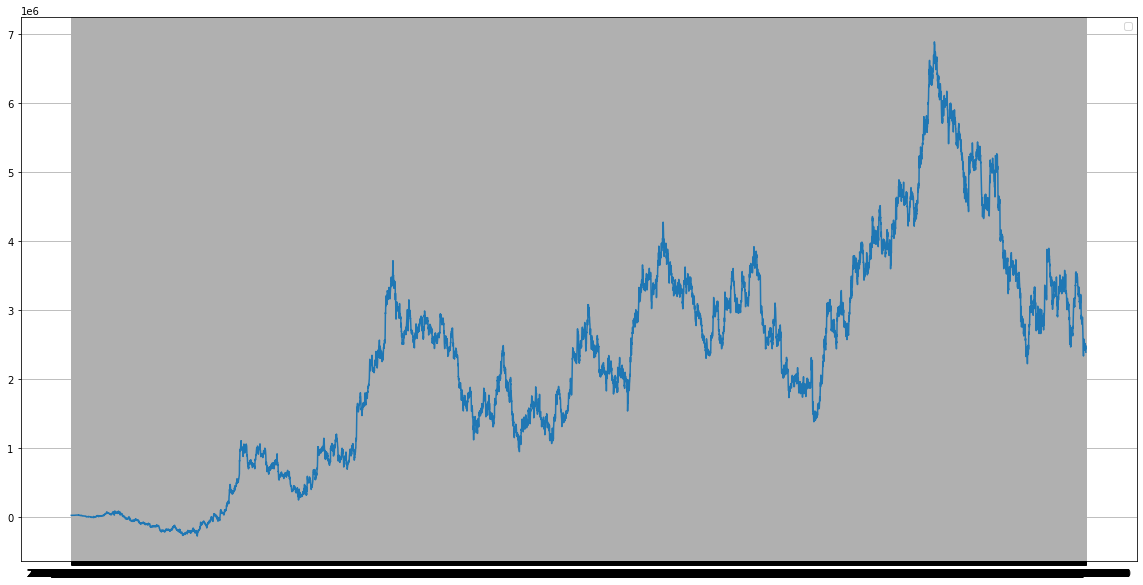

In [147]:
plt.figure(figsize = (20,10))
plt.plot(portfolio['total'])
# plt.plot(portfolio['holding_values'],'--')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# 旭日东升

此策略用在价格横盘后选择突破，向上突破则做多，向下突破则做空

## 做多

In [33]:
rb2301_1204 = pd.read_csv('RB2301 20221204.csv')  # ,dtype={"SSS": int64}

In [34]:
klines = rb2301_1204.filter(['time','open','close','high','low','volume'])

In [478]:
# 对均线的短中长周期设参数
# s1,s2,s3 = 4, 8, 24
# s1,s2,s3 = 8, 16, 48
# s1,s2,s3 = 12, 24, 72
# s1,s2,s3 = 20,40,120
s0=4
s1,s2,s3 = 8,16,32
m1,m2,m3 = 32,64,128
l1,l2,l3 = 128,256,512
# s1,s2,s3 = 8,13,21
# m1,m2,m3 = 21,34,55
# l1,l2,l3 = 55,89,144
kls=0.2
klm=1
kls=1.2
zig1=0.4/100
zig2=0.9/100
zig3=1.6/100
# bin=[-1000,-50,-20,-15,-10, -5, 0, 5, 10,15, 20, 50,1000] #为万分之 [ ) 左关 右开
# bin=[950,980,985,990,995,1000,1005,1010,1015,1020,1050,2000]
#  0    1   2   3  4   5  6  7  8  9  10  11 
# bin=[-20,-5,-3, -2, -1, 0, 1, 2, 3, 5, 20]  #为千分之, 最大为千分之20，即百分之2
# bin =[-20,-5,-3.3,-2,-0.8, 0, 0.8, 2, 3.3, 5, 20]
# 1.5 
bin =[-20,-5,-3,-1.9,-0.8, 0, 0.8, 1.9, 3, 5, 20]
# bin =[-20,-5,-3,-1.8,-0.7, 0, 0.7, 1.8, 3, 5, 20]
# [inf,20)  极端波动
# [20,5) 异常波动
#[5,3.3) 大阳
#[3.3,2]  中涨
#[2,0.8]  小涨
#[0.8,-0.8] 震荡
#[-0.8, -2] 小跌
#[-2, -3.3] 中跌
#[-3.-3,5] 大跌
#[-5,-20] 异常
#[-20, -inf]

In [36]:
vol_bin=[3.2,2.2,1.2,1,0.85,0.5]

In [37]:
bin
#  [-20, -5, -3, -2, -1, 0,  1,   2,   3,  5, 20]
#  [-20, -5, -3.3, -2, -0.8, 0, 0.8, 2, 3.3, 5, 20]
#  [0,   1,   2,  3,  4, 5, 6, 7, 8, 9, 10   11 ]
# 10 11 [inf,20)  极端波动
# 9 10 [20,5) 异常波动
# 8 9 [5,3.3) 大阳
# 7 8 [3.3,2]  中涨
# 6 7 [2,0.8]  小涨
# 5 6 [0.8,-0.8] 震荡
# 4 5 [-0.8, -2] 小跌
# 3 4 [-2, -3.3] 中跌
# 2 3 [-3.-3,5] 大跌
# 1 2 [-5,-20] 异常
# 0 1 [-20, -inf]

[-20, -5, -3, -1.9, -0.8, 0, 0.8, 1.9, 3, 5, 20]

In [38]:
4, 2.5, 1.4 

(4, 2.5, 1.4)

In [39]:
小涨=(bin[3]+bin[4])/2
小涨

-1.35

In [40]:
中涨=(bin[2]+bin[3])/2
中涨

-2.45

In [41]:
大涨=(bin[1]+bin[2])/2
大涨

-4.0

In [42]:
大涨/小涨

2.962962962962963

In [43]:
中涨/小涨

1.8148148148148149

In [44]:
# 对长上影/下影分类  ma_body 的2倍以上就是
ups,lows = 2,2
#回踩反抽
huicai_range = 0.5

In [45]:
# 对vol 最高第二高进行定位
vs=12
vm=46
vl=120

In [46]:
# 对最高最低进行定位

### calc_base_data

In [676]:
def calc_base_data(klinesC):
    klinesC = klines.copy()
    klinesC['vol_prev'] = klinesC.volume.shift(1)
    klinesC['c_prev'] = klinesC.close.shift(1)
    
    # 基础数据 均线类
    klinesC['ma1'] = EMA(klines, s1)
    klinesC['ma2'] = EMA(klines, s2)
    klinesC['ma3'] = EMA(klines, s3)
    klinesC['ma4'] = EMA(klines, m2)
    klinesC['ma5'] = EMA(klines, m3) 
    klinesC['ma6'] = EMA(klines, l2) 
    klinesC['ma7'] = EMA(klines, l3)
#     klinesC['ma4'] = EMA(klines, m1)
#     klinesC['ma5'] = EMA(klines, m2)  
#     klinesC['ma6'] = EMA(klines, m3)  
#     klinesC['ma7'] = EMA(klines, l1)  
#     klinesC['ma8'] = EMA(klines, l2)  
#     klinesC['ma9'] = EMA(klines, l3)
    
    klinesC['ma12_ratio'] = klinesC.ma1/klinesC.ma2
    klinesC['ma23_ratio'] = klinesC.ma2/klinesC.ma3
    klinesC['ma34_ratio'] = klinesC.ma3/klinesC.ma4
    klinesC['ma45_ratio'] = klinesC.ma4/klinesC.ma5
    klinesC['ma56_ratio'] = klinesC.ma5/klinesC.ma6
    klinesC['ma67_ratio'] = klinesC.ma6/klinesC.ma7
    klinesC['ma13_ratio'] = klinesC.ma1/klinesC.ma3
    klinesC['ma24_ratio'] = klinesC.ma2/klinesC.ma4
    klinesC['ma35_ratio'] = klinesC.ma3/klinesC.ma5
    klinesC['ma46_ratio'] = klinesC.ma4/klinesC.ma6
    klinesC['ma57_ratio'] = klinesC.ma5/klinesC.ma7
    
    # get vol stats
    # 基础数据 均量类
    klinesC['mv1'] = ma(klinesC.volume, vs)
    klinesC['mv2'] = ma(klinesC.volume, vm)
    klinesC['mv3'] = ma(klinesC.volume, vl)
    
    # 衍生基础数据 斜率
    klinesC['slp1'] = round(klinesC.ma1 / klinesC.ma1.shift(1) * 1000, 2)
    klinesC['slp2'] = round(klinesC.ma2 / klinesC.ma2.shift(1) * 1000, 2)
    klinesC['slp3'] = round(klinesC.ma3 / klinesC.ma3.shift(1) * 1000, 2)
    klinesC['slp4'] = round(klinesC.ma4 / klinesC.ma4.shift(1) * 1000, 2)
    klinesC['slp5'] = round(klinesC.ma5 / klinesC.ma5.shift(1) * 1000, 2)
    klinesC['slp6'] = round(klinesC.ma6 / klinesC.ma6.shift(1) * 1000, 2)
    klinesC['slp7'] = round(klinesC.ma7 / klinesC.ma7.shift(1) * 1000, 2)
#     klinesC['slp8'] = round(klinesC.ma8 / klinesC.ma8.shift(1) * 1000, 2)
#     klinesC['slp9'] = round(klinesC.ma9 / klinesC.ma9.shift(1) * 1000, 2)    
 
    # 衍生基础数据 偏离 
#     klinesC['bias0'] = round((klinesC.close / klinesC.ma0 - 1) * 1000, 2)
#     klinesC['bias1'] = round((klinesC.close / klinesC.ma1 - 1) * 1000, 2)
#     klinesC['bias2'] = round((klinesC.close / klinesC.ma2 - 1) * 1000, 2)
#     klinesC['bias3'] = round((klinesC.close / klinesC.ma3 - 1) * 1000, 2) 
#     klinesC['bias4'] = round((klinesC.close / klinesC.ma4 - 1) * 1000, 2)
#     klinesC['bias5'] = round((klinesC.close / klinesC.ma5 - 1) * 1000, 2)
#     klinesC['bias6'] = round((klinesC.close / klinesC.ma6 - 1) * 1000, 2)
#     klinesC['bias7'] = round((klinesC.close / klinesC.ma7 - 1) * 1000, 2)
#     klinesC['bias8'] = round((klinesC.close / klinesC.ma8 - 1) * 1000, 2)
#     klinesC['bias9'] = round((klinesC.close / klinesC.ma9 - 1) * 1000, 2)
    
    klinesC['bias1'] = round((1 - klinesC.ma1 / klinesC.close) * 1000, 3)
    klinesC['bias2'] = round((1 - klinesC.ma2 / klinesC.close) * 1000, 3)
    klinesC['bias3'] = round((1 - klinesC.ma3 / klinesC.close) * 1000, 3) 
    klinesC['bias4'] = round((1 - klinesC.ma4 / klinesC.close) * 1000, 3)
    klinesC['bias5'] = round((1 - klinesC.ma5 / klinesC.close) * 1000, 3)
    klinesC['bias6'] = round((1 - klinesC.ma6 / klinesC.close) * 1000, 3)
    klinesC['bias7'] = round((1 - klinesC.ma7 / klinesC.close) * 1000, 3)
#     klinesC['bias8'] = round((1 - klinesC.ma8 / klinesC.close) * 1000, 3)
#     klinesC['bias9'] = round((1 - klinesC.ma9 / klinesC.close) * 1000, 3)
    
    klinesC['df_ma12'] = round((klinesC.ma1 - klinesC.ma2)*1000/klinesC.close,3)
    klinesC['df_ma23'] = round((klinesC.ma2 - klinesC.ma3)*1000/klinesC.close,3)
    klinesC['df_ma34'] = round((klinesC.ma3 - klinesC.ma4)*1000/klinesC.close,3)
    klinesC['df_ma45'] = round((klinesC.ma4 - klinesC.ma5)*1000/klinesC.close,3)
    klinesC['df_ma56'] = round((klinesC.ma5 - klinesC.ma6)*1000/klinesC.close,3)
    klinesC['df_ma67'] = round((klinesC.ma6 - klinesC.ma7)*1000/klinesC.close,3)
#     klinesC['df_ma78'] = round((klinesC.ma7 - klinesC.ma8)*1000/klinesC.close,3)
#     klinesC['df_ma89'] = round((klinesC.ma8 - klinesC.ma9)*1000/klinesC.close,3)
    
    # 衍生数据 偏离的最大最小值
    klinesC['ma_max_13'] = klinesC[['ma1','ma2','ma3']].max(1)
    klinesC['ma_min_13'] = klinesC[['ma1','ma2','ma3']].min(1)
    
#     klinesC['ma_max_14'] = klinesC[['ma1','ma2','ma3','ma4','ma5']].max(1)
#     klinesC['ma_min_14'] = klinesC[['ma1','ma2','ma3','ma4','ma5']].min(1)
    klinesC['ma_max_14'] = klinesC[['ma1','ma2','ma3','ma4']].max(1)
    klinesC['ma_min_14'] = klinesC[['ma1','ma2','ma3','ma4']].min(1)    
    
    klinesC['ma_max_35'] = klinesC[['ma3','ma4','ma5']].max(1)
    klinesC['ma_min_35'] = klinesC[['ma3','ma4','ma5']].min(1)

    klinesC['ma_max_57'] = klinesC[['ma5','ma6','ma7']].max(1)
    klinesC['ma_min_57'] = klinesC[['ma5','ma6','ma7']].min(1)
 
    klinesC['ma_max_15'] = klinesC[['ma1','ma2','ma3','ma4','ma5']].max(1)
    klinesC['ma_min_15'] = klinesC[['ma1','ma2','ma3','ma4','ma5']].min(1) 
 
    klinesC['ma_max_17'] = klinesC[['ma1','ma2','ma3','ma4','ma5','ma6','ma7']].max(1)
    klinesC['ma_min_17'] = klinesC[['ma1','ma2','ma3','ma4','ma5','ma6','ma7']].min(1) 
    
    # 形态数据  靠拢
    klinesC['rng_ma13'] = klinesC.ma_max_13 - klinesC.ma_min_13
    klinesC['rng_ma35'] = klinesC.ma_max_35 - klinesC.ma_min_35
    klinesC['rng_ma57'] = klinesC.ma_max_57 - klinesC.ma_min_57

    klinesC['rng_15'] = klinesC.ma_max_15 - klinesC.ma_min_15
    klinesC['rng_17'] = klinesC.ma_max_17 - klinesC.ma_min_17
    
    #均线衍生 均线间距
#   klinesC['df_01'] = klinesC.ma0 - klinesC.ma1
#     klinesC['df_ma12'] = klinesC.ma1 - klinesC.ma2
#     klinesC['df_ma23'] = klinesC.ma2 - klinesC.ma3
#     klinesC['df_ma34'] = klinesC.ma3 - klinesC.ma4
#     klinesC['df_ma45'] = klinesC.ma4 - klinesC.ma5  
#     klinesC['df_ma56'] = klinesC.ma5 - klinesC.ma6    
#     klinesC['df_ma67'] = klinesC.ma6 - klinesC.ma7
    
#     klinesC['ma78_df'] = klinesC.ma7 - klinesC.ma8
#     klinesC['ma89_df'] = klinesC.ma8 - klinesC.ma9
            
    # 均线衍生 平均斜率
    klinesC['mslp1'] = ma(klinesC.slp1, 2) # 用于判断回调
    klinesC['mslp2'] = ma(klinesC.slp2, 8)
    klinesC['mslp3'] = ma(klinesC.slp3, 10)
    klinesC['mslp4'] = ma(klinesC.slp4, 10)
    klinesC['mslp5'] = ma(klinesC.slp5, 12)
    klinesC['mslp6'] = ma(klinesC.slp6, 14)
    klinesC['mslp7'] = ma(klinesC.slp7, 20)
    
#     klinesC['mslp8'] = ma(klinesC.slp8, 30)
#     klinesC['mslp9'] = ma(klinesC.slp9, 40)

    #均线衍生 均绝对偏离
    #     klinesC['ma_2_slp0'] = ma(klinesC.slp0, 2)     klinesC['ma_body'] = ma(abs(klinesC.cdlBody), 20)
#     klinesC['mbias1s'] = ma(abs(klinesC.bias1s), 20)  # 获取20日绝对bias1的平均
#     klinesC['mbias2s'] = ma(abs(klinesC.bias2s), 20)  # 获取20日绝对bias2的平均
#     klinesC['mbias3s'] = ma(abs(klinesC.bias3s), 20) 
    
#     klinesC['mbias1m'] = ma(abs(klinesC.bias1m), 30)  # 获取20日绝对bias1的平均
#     klinesC['mbias2m'] = ma(abs(klinesC.bias2m), 30)  # 获取20日绝对bias2的平均
#     klinesC['mbias3m'] = ma(abs(klinesC.bias3m), 30) 
    
#     klinesC['mbias1l'] = ma(abs(klinesC.bias1l), 40)  # 获取20日绝对bias1的平均
#     klinesC['mbias2l'] = ma(abs(klinesC.bias2l), 40)  # 获取20日绝对bias2的平均
#     klinesC['mbias3l'] = ma(abs(klinesC.bias3l), 4 0) 

    #均线衍生 均偏离    
    klinesC['m_bias1'] = ma(klinesC.bias1,7)
    klinesC['m_bias2'] = ma(klinesC.bias2,10)
    klinesC['m_bias3'] = ma(klinesC.bias3,17)
    klinesC['m_bias4'] = ma(klinesC.bias4,20)
    klinesC['m_bias5'] = ma(klinesC.bias5,25)
    klinesC['m_bias6'] = ma(klinesC.bias6,30)
    klinesC['m_bias7'] = ma(klinesC.bias7,40)
    
#     klinesC['m_bias8'] = ma(klinesC.bias8,30)
#     klinesC['m_bias9'] = ma(klinesC.bias9,40)    
    
#   均线衍生  计算价格对平均偏移的diff
    klinesC['df_m_bias1'] = klinesC.close - klinesC.m_bias1
    klinesC['df_m_bias2'] = klinesC.close - klinesC.m_bias2
    klinesC['df_m_bias3'] = klinesC.close - klinesC.m_bias3
    klinesC['df_m_bias4'] = klinesC.close - klinesC.m_bias4
    klinesC['df_m_bias5'] = klinesC.close - klinesC.m_bias5
    klinesC['df_m_bias6'] = klinesC.close - klinesC.m_bias6
    klinesC['df_m_bias7'] = klinesC.close - klinesC.m_bias7
    
#     klinesC['m_bias8_df'] = klinesC.close - klinesC.m_bias8
#     klinesC['m_bias9_df'] = klinesC.close - klinesC.m_bias9    
       
    # 基础 计算K线的特征
    klinesC['pct_chg'] = round(klinesC.close.pct_change() * 1000,2)
    klinesC['zdf'] = klinesC.close - klinesC.close.shift(1)
    klinesC['abs_zdf'] = abs(klinesC.zdf)
    klinesC['kbody'] = klinesC.close - klinesC.open
    klinesC['abs_body'] = abs(klinesC.kbody)
    klinesC['kbody_top'] = klinesC[['close','open']].max(axis=1)
    klinesC['kbody_button'] = klinesC[['close','open']].min(axis=1)
    klinesC['kbody_pct'] = round(klinesC.abs_body / klinesC.c_prev * 1000, 2) #k线实体的振幅
    klinesC['k_hl'] = klinesC.high - klinesC.low  # k线的 full length = H - L
    klinesC['k_hl_pct'] = klinesC.k_hl / klinesC.c_prev * 1000  # K线的振幅
    klinesC['k_ho'] = klinesC.high - klinesC.open  # 可以作为 多头
    klinesC['k_hc'] = klinesC.high - klinesC.close  # 可以作为空头
    klinesC['k_ups'] = klinesC[['k_ho', 'k_hc']].min(axis=1)  # 上影线upper shadow
    klinesC['k_ups_pct'] = klinesC.k_ups / klinesC.close * 1000  #上影线振幅
    klinesC['k_lo'] = klinesC.open - klinesC.low  # 可以作为 空头
    klinesC['k_lc'] = klinesC.close - klinesC.low  #
    klinesC['k_lows'] = klinesC[['k_lo', 'k_lc']].min(axis=1)  # 下影线 lower shadow
    klinesC['k_lows_pct'] = klinesC.k_lows / klinesC.close * 1000 #下影线振幅
    klinesC['ma_kbody'] = ma(klinesC.abs_body, 20)
    klinesC['long_ups'] = klinesC.k_ups / klinesC.ma_kbody > ups  # 上影
    klinesC['long_lows'] = klinesC.k_lows / klinesC.ma_kbody > lows # 下影    
    klinesC['ma_ups'] = ma(klinesC.k_ups, 20) # 获取upper shadow 均值
    klinesC['ma_lows'] = ma(klinesC.k_lows, 20) # 获取lower shadow 均值     
    
    # 计算买卖压
    klinesC['zd_strength'] = klinesC.abs_body / klinesC.ma_kbody  # 涨跌力度
    
    # 描述交易量
    # 交易量分类 vol strength
    klinesC['v1_strength'] = klinesC.volume / klinesC.mv1.shift(1)
    klinesC['v2_strength'] = klinesC.volume / klinesC.mv2.shift(1)
    klinesC['v3_strength'] = klinesC.volume / klinesC.mv3.shift(1)
    klinesC['mv13_ratio'] = klinesC.mv1 / klinesC.mv3
    klinesC['mv12_ratio'] = klinesC.mv1 / klinesC.mv2
    klinesC['mv23_ratio'] = klinesC.mv2 / klinesC.mv3

    # 巨量统计
    klinesC['jl_1d'] = (klinesC.v3_strength >= 3)
    klinesC['jl_tj'] = count(klinesC.jl_1d, 20)  # 巨量统计
    klinesC['jl_2d'] = klinesC.jl_1d & klinesC.jl_1d.shift(1)  # 连续2天放量
    klinesC['jl_3d'] = klinesC.jl_2d & klinesC.jl_2d.shift(1)  # 连续3天放量

    #定位巨量位置
    klinesC['jl_1d_last_days'] = barlast(klinesC.jl_1d == True)
    klinesC['jl_2d_last_days'] = barlast(klinesC.jl_2d == True)
    klinesC['jl_3d_last_days'] = barlast(klinesC.jl_3d == True)
    
    # 求最大量 第二/第三 量
    klinesC['hhv_vol_'+ str(vs)] = hhv(klinesC.volume,vs)
    klinesC['hhv_vol_'+ str(vm)] = hhv(klinesC.volume,vm)
    klinesC['hhv_vol_'+ str(vl)] = hhv(klinesC.volume,vl)

    #量价关系
    
    ## 形态数据 均线形态
#     klinesC['ktpl_13'] = ((klinesC.ma1 <= klinesC.ma2) & (klinesC.ma2 <= klinesC.ma3))  # 空头排列 ma1,2,3
#     klinesC['dtpl_13'] = ((klinesC.ma1 >= klinesC.ma2) & (klinesC.ma2 >= klinesC.ma3))  # 多头排列 ma1,2,3
#     klinesC['ktpl_46'] = ((klinesC.ma3 <= klinesC.ma4) & (klinesC.ma4 <= klinesC.ma6))  # 空头排列 ma1,2,3
#     klinesC['dtpl_46'] = ((klinesC.ma3 >= klinesC.ma4) & (klinesC.ma4 >= klinesC.ma6))  # 多头排列 ma1,2,3
#     klinesC['ktpl_79'] = ((klinesC.ma7 <= klinesC.ma8) & (klinesC.ma8 <= klinesC.ma9)) # 空头排列 ma2,3,4
#     klinesC['dtpl_79'] = ((klinesC.ma7 >= klinesC.ma8) & (klinesC.ma8 >= klinesC.ma9)) # 多头排列 ma2,3,4    
           
    # 价格zigzag
    klinesC['zig1'] = peak_valley_pivots(klines.close, zig1, -zig1)
    klinesC['zig2'] = peak_valley_pivots(klines.close, zig2, -zig2)
    klinesC['zig3'] = peak_valley_pivots(klines.close, zig3, -zig3)
    klinesC['valley1'] = barlast(klinesC.zig1 == -1)
    klinesC['peak1'] = barlast(klinesC.zig1 == 1)
    klinesC['valley2'] = barlast(klinesC.zig2 == -1)
    klinesC['peak2'] = barlast(klinesC.zig2 == 1)
    klinesC['valley3'] = barlast(klinesC.zig3 == -1)
    klinesC['peak3'] = barlast(klinesC.zig3 == 1)

#     klinesC['price_pos'] = get_price_pos(klinesC[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']])
#     klinesC['min_bias'] = get_min_bias(klinesC[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']])
    klinesC['min_bias13'] = get_min_bias(klinesC[['bias1','bias2','bias3']]) # dt_13 if min_bias13>0
    klinesC['min_bias35'] = get_min_bias(klinesC[['bias3','bias4','bias5']])
    klinesC['min_bias57'] = get_min_bias(klinesC[['bias5','bias6','bias7']])
#     bias=klinesC[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']]
    bias=klinesC[['bias1','bias2','bias3','bias4','bias5','bias6','bias7']]
#     df_ma = klinesC[['df_ma12','df_ma23','df_ma34','df_ma45','df_ma56','df_ma67','df_ma78','df_ma89']]
    df_ma = klinesC[['df_ma12','df_ma23','df_ma34','df_ma45','df_ma56','df_ma67']]
    #price_pos min_bias 的输入为ma1-9
    #price_in_ma 0 - ma1-2, 1-> ma2-3, 3->ma3,ma5(第三第四ma)
    klinesC[['price_in_ma','price_in_ma_cnt','price_pos','min_bias']] = get_price_stage(bias,df_ma)
    klinesC['huicai'] = abs(klinesC.min_bias) <= huicai_range # 用于回踩或者反抽策略      
    # 3均线多空形态
#     klinesC[['ma_stage1_3','ma_stage2_4','ma_stage3_5','ma_stage4_6','ma_stage5_7']]=get_ma_stage(bias)[0]
    # 3均线区间值
#     klinesC[['ma_rng1_3','ma_rng2_4','ma_rng3_5','ma_rng4_6','ma_rng5_7']]=get_ma_stage(bias)[1]
#     klinesC['price_stage'] = klinesC.apply()
    klinesC['mv_stage'] =get_mv_stage(klinesC[['v1_strength','v2_strength','v3_strength','mv13_ratio','mv23_ratio','mv12_ratio']])[:,18]
    
    klinesC['ma_stage_s'] = get_ma_stage(klinesC[['ma12_ratio','ma23_ratio','ma13_ratio']],1,3)[:,18]
    klinesC['ma_stage_m'] = get_ma_stage(klinesC[['ma34_ratio','ma45_ratio','ma35_ratio']],1,3)[:,18]
    klinesC['ma_stage_l'] = get_ma_stage(klinesC[['ma56_ratio','ma67_ratio','ma57_ratio']],1,3)[:,18]
    return klinesC

In [677]:
# %time 
start=datetime.datetime.now()
base = calc_base_data(klines)
datetime.datetime.now()-start
# base=calc_base_data(klines)

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

datetime.timedelta(microseconds=244039)

In [683]:
# get_ma_stage(base[['ma12_ratio','ma23_ratio','ma13_ratio']],1,3)[:,18].max()
get_ma_stage(base[['ma56_ratio','ma67_ratio','ma57_ratio']],1,3)[:,18].max()

18.0

In [544]:
bias=base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7']]
df_ma = base[['df_ma12','df_ma23','df_ma34','df_ma45','df_ma56','df_ma67']]

In [684]:
ma_res=base[['ma_stage_s','ma_stage_m','ma_stage_l']]

In [685]:
chg_pair,chg_cnt = np.unique(ma_res,axis=0,return_counts=True)
chg_pair_cnt = list(zip(chg_pair,chg_cnt))
res = sorted(chg_pair_cnt,key=lambda x:x[1])
res

[(array([1., 4., 6.]), 1),
 (array([1., 5., 3.]), 1),
 (array([1., 8., 5.]), 1),
 (array([ 1., 10.,  7.]), 1),
 (array([ 1., 10., 16.]), 1),
 (array([ 1., 16., 13.]), 1),
 (array([ 2.,  5., 15.]), 1),
 (array([2., 9., 3.]), 1),
 (array([ 2.,  9., 12.]), 1),
 (array([ 2., 10.,  5.]), 1),
 (array([ 2., 10., 12.]), 1),
 (array([ 2., 13.,  9.]), 1),
 (array([ 2., 14., 15.]), 1),
 (array([ 2., 15.,  7.]), 1),
 (array([ 2., 15., 12.]), 1),
 (array([ 2., 17.,  3.]), 1),
 (array([ 2., 17., 13.]), 1),
 (array([ 2., 18., 12.]), 1),
 (array([ 2., 18., 13.]), 1),
 (array([3., 1., 2.]), 1),
 (array([ 3.,  2., 16.]), 1),
 (array([ 3.,  3., 16.]), 1),
 (array([3., 4., 6.]), 1),
 (array([ 3.,  5., 15.]), 1),
 (array([ 3., 11.,  5.]), 1),
 (array([ 3., 11., 16.]), 1),
 (array([ 3., 13.,  6.]), 1),
 (array([ 3., 15., 15.]), 1),
 (array([ 3., 17.,  6.]), 1),
 (array([ 4.,  1., 12.]), 1),
 (array([4., 2., 6.]), 1),
 (array([4., 2., 8.]), 1),
 (array([ 4.,  2., 18.]), 1),
 (array([4., 6., 2.]), 1),
 (array

In [686]:
chg_pair.shape

(769, 3)

In [545]:
hc = base.huicai==1

In [559]:
base.filter(['close','ma1','ma2','ma3','ma4','ma5','ma6','ma7','price_in_ma','price_in_ma_cnt','price_pos','min_bias'])

,close,ma1,ma2,ma3,ma4,ma5,ma6,ma7,price_in_ma,price_in_ma_cnt,price_pos,min_bias
0,4647,4647.000000,4647.000000,4647.000000,4647.000000,4647.000000,4647.000000,4647.000000,"[0, 1, 2, 3, 4, 5]",6,0,0.000
1,4641,4645.666667,4646.294118,4646.636364,4646.815385,4646.906977,4646.953307,4646.976608,None,-99,0,-1.006
2,4646,4645.740741,4646.259516,4646.597796,4646.790296,4646.892915,4646.945889,4646.972801,[0],1,0,0.056
3,4641,4644.687243,4645.640749,4646.258536,4646.612133,4646.801552,4646.899617,4646.949515,None,-99,0,-0.794
4,4647,4645.201189,4645.800661,4646.303473,4646.624067,4646.804629,4646.900398,4646.949712,None,99,6,0.011
...,...,...,...,...,...,...,...,...,...,...,...,...
8395,3778,3774.132004,3773.639061,3774.762644,3773.111398,3768.163836,3760.146480,3743.003501,None,99,2,0.857
8396,3780,3775.436003,3774.387407,3775.080060,3773.323355,3768.347343,3760.300982,3743.147737,None,99,0,1.207
8397,3783,3777.116891,3775.400653,3775.560056,3773.621098,3768.574516,3760.477628,3743.303106,None,99,0,1.555
8398,3789,3779.757582,3777.000576,3776.374598,3774.094295,3768.891190,3760.699592,3743.481262,None,99,0,2.439


In [579]:
base.groupby(['price_in_ma_cnt']).count()

,time,open,close,high,low,volume,vol_prev,c_prev,ma1,ma2,...,valley3,peak3,min_bias13,min_bias35,min_bias57,price_in_ma,price_pos,min_bias,huicai,mv_stage
price_in_ma_cnt,,,,,,,,,,,,,,,,,,,,,
-99,2050,2050,2050,2050,2050,2050,2050,2050,2050,2050,...,2050,2050,2050,2050,2050,0,2050,2050,2050,2050
1,3442,3442,3442,3442,3442,3442,3442,3442,3442,3442,...,3442,3442,3442,3442,3442,3442,3442,3442,3442,3442
2,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,...,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073
3,98,98,98,98,98,98,98,98,98,98,...,98,98,98,98,98,98,98,98,98,98
4,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
6,1,1,1,1,1,1,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
99,1729,1729,1729,1729,1729,1729,1729,1729,1729,1729,...,1729,1729,1729,1729,1729,2,1729,1729,1729,1729


In [458]:
np.unique(base.price_pos)

array([0, 1, 2, 4, 5, 7, 8], dtype=int64)

In [491]:
base[base.price_in_ma_cnt != 0]

,time,open,close,high,low,volume,vol_prev,c_prev,ma1,ma2,...,peak3,min_bias13,min_bias35,min_bias57,price_in_ma,price_in_ma_cnt,price_pos,min_bias,huicai,mv_stage
0,2022/06/07-14:40,4647,4647,4650,4644,882,NaN,NaN,4647.000000,4647.000000,...,0,0.000,0.000,0.000,"[0, 1, 2, 3, 4, 5]",6.0,0,0.000,True,0.0
111,2022/06/09-10:10,4721,4717,4731,4715,1176,442.0,4720.0,4724.171524,4728.023658,...,32,-1.520,-1.198,2.625,[0],1.0,3,-1.198,False,0.0
953,2022/06/27-13:35,4225,4225,4226,4218,1724,1375.0,4225.0,4229.732515,4232.672731,...,114,-0.821,-0.821,5.686,[0],1.0,2,-0.821,False,18.0
1098,2022/06/29-14:10,4328,4336,4337,4326,2806,1477.0,4329.0,4325.131948,4318.615043,...,259,2.506,5.474,12.918,[0],1.0,0,2.506,False,2.0
1158,2022/06/30-11:25,4293,4321,4322,4288,2521,3567.0,4292.0,4303.694463,4308.533421,...,56,1.299,0.810,3.427,[2],1.0,3,0.810,False,15.0
1586,2022/07/08-14:35,4128,4138,4142,4120,1788,869.0,4127.0,4125.350403,4127.039167,...,54,0.688,0.688,-3.254,[4],1.0,2,0.688,False,11.0
1709,2022/07/12-11:20,3950,3952,3956,3946,1452,754.0,3951.0,3946.397965,3948.662777,...,47,0.844,-0.878,-13.934,[0],1.0,1,0.844,False,8.0
1720,2022/07/12-14:15,3913,3911,3915,3909,765,1208.0,3914.0,3918.180402,3926.273254,...,58,-1.836,-6.891,-21.108,[2],1.0,0,-1.836,False,8.0
2123,2022/07/20-11:20,3766,3757,3768,3754,2244,2154.0,3766.0,3758.798404,3750.973031,...,54,-0.479,5.341,-8.983,[2],1.0,0,-0.479,True,11.0
2731,2022/08/02-10:00,3912,3916,3918,3911,1871,1882.0,3912.0,3915.621372,3919.016414,...,83,0.097,-2.434,-2.460,[2],1.0,0,0.097,True,14.0


In [367]:
ma_ratio = base[['ma12_ratio','ma23_ratio','ma34_ratio','ma45_ratio','ma56_ratio','ma67_ratio']]

In [360]:
# 小空头 回踩ma1   162
tt1 = (base.ma_stage1_3==-1) & (base.huicai==0) & (base.price_pos==1)
# 小多头 回踩ma1 141
tt2 = (base.ma_stage1_3==1) & (base.huicai==0) & (base.price_pos==1)



In [50]:
tt2.sum()

141

In [56]:
vdata = base[['volume','vol_prev','mv1','mv2','mv3','vol1_strength','vol2_strength','vol3_strength','mv13_ratio','mv23_ratio','mv12_ratio']]

In [40]:
df_ma = base[['df_ma12','df_ma23','df_ma34','df_ma45','df_ma56','df_ma67','df_ma78','df_ma89']]
bias=base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']]

In [41]:
base.price_in_ma

0       [0, 1, 2, 3, 4, 5]
1                     None
2                      [0]
3                     None
4                     None
               ...        
8395                  None
8396                  None
8397                  None
8398                  None
8399                  None
Name: price_in_ma, Length: 8400, dtype: object

In [54]:
pd.set_option("display.max_rows",None)

In [63]:
pd.set_option('display.max_columns', None)

In [69]:
# [0,1,2,3,4,5,6]
# [1,2,3,4,5,6,7]  逻辑上的ma编码
# [1,2,3,5,6,8,9]  实际的ma名字编码
# price_pos 0 =ma1，
base[['close','ma1','ma2','ma3','ma5','ma6','ma8','ma9','price_in_ma','price_in_ma_cnt','price_pos',
      'min_bias','bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']]\
    .query('price_in_ma_cnt==1 and price_pos in (4,5)').iloc[-20:,:]
#     .query('price_in_ma_cnt==1 and price_pos in (2,4)').iloc[-20:,:]
#     .query('price_in_ma_cnt==1 and price_pos in (1,2)').iloc[-20:,:]
#         .query('price_in_ma_cnt==1 and price_pos in (0,1)').iloc[-20:,:]

# 解读price_in_ma price_pos解读
# price_in_ma desc   price_pos   price_pos   price_in_ma
# [0]         ma12   0 or 1      0           null or [0]
# [1]         ma23   1 or 2      1           [0]
# [2]         ma3,5  2 or 4      2
# [3]         ma5,6  4 or 5      4
# [4]         ma6,8  5 or 7      5
# [5]         ma8,9              7
#                                8

,close,ma1,ma2,ma3,ma5,ma6,ma8,ma9,price_in_ma,price_in_ma_cnt,price_pos,min_bias,bias1,bias2,bias3,bias4,bias5,bias6,bias7,bias8,bias9
8147,3768,3769.673801,3773.772612,3775.874461,3769.556760,3753.860603,3733.663710,3711.015722,[3],1.0,4,-0.413,-0.444,-1.532,-2.090,-2.090,-0.413,3.752,3.752,9.113,15.123
8155,3772,3776.482258,3776.274938,3776.599017,3771.353722,3756.656554,3736.328144,3713.065320,[2],1.0,4,0.171,-1.188,-1.133,-1.219,-1.219,0.171,4.068,4.068,9.457,15.624
8158,3771,3774.808525,3775.405234,3776.083126,3771.556974,3757.434563,3737.192852,3713.771287,[3],1.0,4,-0.148,-1.010,-1.168,-1.348,-1.348,-0.148,3.597,3.597,8.965,15.176
8159,3765,3772.628853,3774.181089,3775.411422,3771.355221,3757.551857,3737.409250,3713.971009,[3],1.0,4,-1.688,-2.026,-2.439,-2.765,-2.765,-1.688,1.978,1.978,7.328,13.554
8169,3750,3759.978665,3764.980566,3769.387132,3769.110644,3758.376245,3739.360733,3715.866084,[4],1.0,5,-2.234,-2.661,-3.995,-5.170,-5.170,-5.096,-2.234,-2.234,2.837,9.102
8258,3755,3766.309259,3765.047228,3760.394923,3756.908359,3755.040237,3746.189305,3726.643225,[4],1.0,5,-0.011,-3.012,-2.676,-1.437,-1.437,-0.508,-0.011,-0.011,2.346,7.552
8274,3754,3766.047426,3768.021209,3766.253238,3762.130007,3758.440405,3749.048345,3729.304833,[4],1.0,5,-1.183,-3.209,-3.735,-3.264,-3.264,-2.166,-1.183,-1.183,1.319,6.578
8275,3757,3764.036887,3766.724596,3765.692436,3761.972160,3758.418073,3749.110226,3729.412806,[4],1.0,5,-0.377,-1.873,-2.588,-2.314,-2.314,-1.323,-0.377,-0.377,2.100,7.343
8376,3771,3782.495918,3783.351189,3780.812822,3774.063491,3766.879379,3758.272305,3740.781118,[3],1.0,4,-0.812,-3.049,-3.275,-2.602,-2.602,-0.812,1.093,1.093,3.375,8.013
8377,3772,3780.163492,3782.015755,3780.278712,3773.999999,3766.958768,3758.379136,3740.902829,[3],1.0,4,-0.530,-2.164,-2.655,-2.195,-2.195,-0.530,1.336,1.336,3.611,8.244


In [79]:
base[['close','ma1','ma2','ma3','ma5','ma6','ma8','ma9','price_in_ma','price_in_ma_cnt','price_pos',
      'min_bias','bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']]\
    .query('price_pos == 8 and price_in_ma_cnt > 0').iloc[-50:,:]

# 解读 price_pos price_in_ma 解读
#price_pos des       price_in_ma
#  0      离ma1最近  null or [0] or 其他    none 可以是多头 空头  震荡区外
#  1      离ma2最近  [0] or [1] or 其他     
#  2      离ma3最近  [1] or [2] or 其他        
#  4   3  离ma5最近  [2] or [3] or 其他            
#  5   4  离ma6最近  [3] or [4] or 其他           
#  7   5  离ma8最近  [4] or [5] or 其他             
#  8   6  离ma9最近  [5] or [6] or 其他          

,close,ma1,ma2,ma3,ma5,ma6,ma8,ma9,price_in_ma,price_in_ma_cnt,price_pos,min_bias,bias1,bias2,bias3,bias4,bias5,bias6,bias7,bias8,bias9
6330,3668,3655.536616,3650.943530,3647.425164,3643.940912,3641.983094,3650.783503,3678.349238,[5],1.0,8,-2.821,3.398,4.650,5.609,5.609,6.559,7.093,7.093,4.694,-2.821
6538,3619,3603.769859,3596.290025,3591.753379,3590.333562,3592.123316,3603.062803,3630.740886,[5],1.0,8,-3.244,4.208,6.275,7.529,7.529,7.921,7.427,7.427,4.404,-3.244
6839,3508,3487.365736,3479.733349,3473.885255,3468.247406,3464.457874,3479.508065,3521.859857,[5],1.0,8,-3.951,5.882,8.058,9.725,9.725,11.332,12.412,12.412,8.122,-3.951
6840,3508,3491.951128,3483.058837,3475.952816,3469.470563,3465.132946,3479.729792,3521.805822,[5],1.0,8,-3.936,4.575,7.110,9.135,9.135,10.983,12.220,12.220,8.059,-3.936
6841,3515,3497.073100,3486.816621,3478.319312,3470.871469,3465.906079,3480.004269,3521.779289,[5],1.0,8,-1.929,5.100,8.018,10.435,10.435,12.554,13.967,13.967,9.956,-1.929
6907,3506,3496.794626,3492.593076,3489.084165,3485.056454,3478.884215,3482.265269,3513.514418,[5],1.0,8,-2.143,2.626,3.824,4.825,4.825,5.974,7.734,7.734,6.770,-2.143
6911,3513,3507.961576,3501.206073,3494.703850,3488.515450,3481.041864,3483.256972,3513.529683,[5],1.0,8,-0.151,1.434,3.357,5.208,5.208,6.970,9.097,9.097,8.467,-0.151
6919,3512,3509.074147,3506.591212,3500.734779,3493.311755,3484.478099,3484.897240,3513.431927,[5],1.0,8,-0.408,0.833,1.540,3.208,3.208,5.321,7.837,7.837,7.717,-0.408
6938,3508,3503.089602,3503.036350,3502.393694,3497.911408,3489.461175,3487.537814,3512.766095,[5],1.0,8,-1.359,1.400,1.415,1.598,1.598,2.876,5.285,5.285,5.833,-1.359
6940,3509,3504.387537,3503.734182,3502.828595,3498.404350,3489.970752,3487.824226,3512.713486,[5],1.0,8,-1.058,1.314,1.501,1.759,1.759,3.020,5.423,5.423,6.035,-1.058


In [1024]:
base[['close','ma1','ma2','ma3','ma5','ma6','ma8','ma9','price_in_ma','price_in_ma_cnt','price_pos','min_bias']].query('price_in_ma_cnt>0').iloc[-20:,:]

,close,ma1,ma2,ma3,ma5,ma6,ma8,ma9,price_in_ma,price_in_ma_cnt,price_pos,min_bias
8371,3783,3783.696642,3783.624240,3779.816599,3772.422443,3765.497614,3757.249735,3739.929272,[1],1.0,1,-0.165
8374,3784,3785.432028,3784.731083,3781.087579,3773.753150,3766.496605,3757.946382,3740.481486,[1],1.0,1,-0.193
8376,3771,3782.495918,3783.351189,3780.812822,3774.063491,3766.879379,3758.272305,3740.781118,[3],1.0,4,-0.812
8377,3772,3780.163492,3782.015755,3780.278712,3773.999999,3766.958768,3758.379136,3740.902829,[3],1.0,4,-0.530
8378,3776,3779.238271,3781.308019,3780.019396,3774.061538,3767.098943,3758.516263,3741.039660,[2],1.0,4,0.513
8379,3776,3778.518656,3780.683546,3779.775796,3774.121183,3767.236944,3758.652323,3741.175958,[2],1.0,4,0.498
8380,3771,3776.847843,3779.544306,3779.243930,3774.025146,3767.295285,3758.748414,3741.292231,[3],1.0,4,-0.802
8381,3771,3775.548322,3778.539093,3778.744297,3773.932065,3767.352723,3758.843757,3741.408051,[3],1.0,4,-0.778
8382,3772,3774.759806,3777.769788,3778.335552,3773.872617,3767.424774,3758.946140,3741.527317,[3],1.0,4,-0.496
8383,3775,3774.813183,3777.443931,3778.133397,3773.907305,3767.542219,3759.071073,3741.657815,"[0, 2]",2.0,0,0.049


<AxesSubplot:>

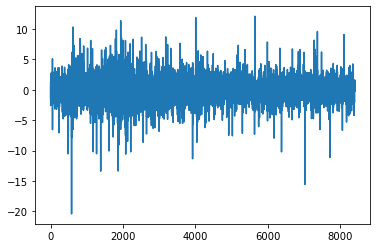

In [730]:
base.pct_chg

In [883]:
bias=base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']]
# df_ma = base[['df_ma12','df_ma23','df_ma34','df_ma45','df_ma56','df_ma67','df_ma78','df_ma89']]
df_ma = base[['df_ma12','df_ma23','df_ma45','df_ma56','df_ma78','df_ma89']]

In [139]:
rr = rolling_window(base.pct_chg.values,10)

In [930]:
data=df_ma.values

In [939]:
ma_stage=np.zeros(data.shape[0])

In [948]:
# p1  ma1,2,3 多头,没有大涨 进攻态势
p1=(0<=data[:,0]) & (data[:,0]<1) & (0<=data[:,1]) & (data[:,1]<1) & (data[:,0]>=data[:,1])
ma_res[p1]=1

In [951]:
# p1  ma1,2,3 多头,没有大涨 调整态势 可能续涨，可能下跌
p2=(0<=data[:,0]) & (data[:,0]<1) & (0<=data[:,1]) & (data[:,1]<1) & (data[:,0]<data[:,1])

In [970]:
p2=(0<=data[:,0]) & (data[:,0]<1) & (0<=data[:,1]) & (data[:,1]<1)
ma_res[p2]=2

In [971]:
i=2
ma_res[globals()['p'+ str(i)]].sum()/i

771.0

In [955]:
i=2

In [956]:
'p'+ str(i)

'p2'

'p+ str(i)'

### 测试分类

In [878]:
from sklearn.cluster import KMeans

In [884]:
data=df_ma.values

In [885]:
n_clusters = 6

In [890]:
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(data)

KMeans(n_clusters=6)

In [902]:
labels = kmeans.predict(data)

In [894]:
labels = kmeans.labels_

In [896]:
labels.shape

(8400,)

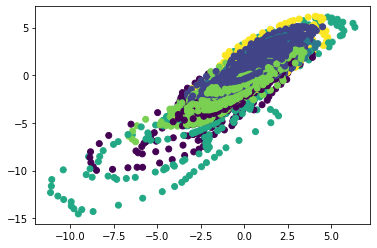

In [893]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.show()

In [926]:
r=0
[[data[labels==r][:,i].max(),data[labels==r][:,i].min()] for i in list(range(data.shape[1]))]

[[3.931, -8.877],
 [2.832, -9.982],
 [2.03, -10.739],
 [-1.401, -11.924],
 [-2.7, -14.919],
 [-1.295, -16.019]]

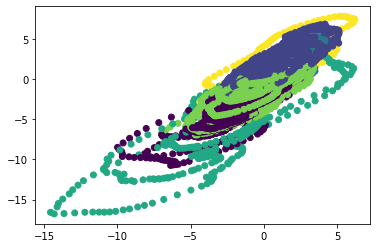

In [898]:
plt.scatter(data[:, 1], data[:, 2], c=labels)
plt.show()

### 统计涨跌

In [673]:
dd=np.digitize(base.pct_chg.values, bin)
# dd=np.digitize(rr, bin)


In [674]:
uniqueValues, occurCount = np.unique(dd, return_counts=True)

In [675]:
res[:,-1].sum()/10

577.9

In [676]:
1974-578

1396

In [677]:
df_raw=pd.DataFrame(zip(bin, occurCount ))

In [683]:
# df=
df.iloc[6,1]

1797

In [687]:
df

,0,1
0,-20.0,1
1,-5.0,73
2,-3.0,291
3,-1.8,721
4,-0.7,1674
5,0.0,1145
6,0.7,1797
7,1.8,1691
8,3.0,650
9,5.0,268


In [662]:
for i in list(range(11)):
    print(f"{df.iloc[i,0]} percentage is {round(df.iloc[i,1]/84,2)}")

-20.0 percentage is 0.01
-5.0 percentage is 0.87
-3.0 percentage is 3.46
-1.9 percentage is 7.01
-0.8 percentage is 18.73
0.0 percentage is 16.4
0.8 percentage is 23.5
1.9 percentage is 19.05
3.0 percentage is 6.71
5.0 percentage is 3.19
20.0 percentage is 1.05


In [663]:
print(f"24天总体下跌的百分比是{round(df.iloc[:6,1].sum()/84,2)}") 

24天总体下跌的百分比是46.49


In [664]:
print(f"24天上涨的百分比是{round(df.iloc[6:,1].sum()/84,2)}") 

24天上涨的百分比是53.5


In [450]:
list(range(11))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

<AxesSubplot:title={'center':'distribution'}>

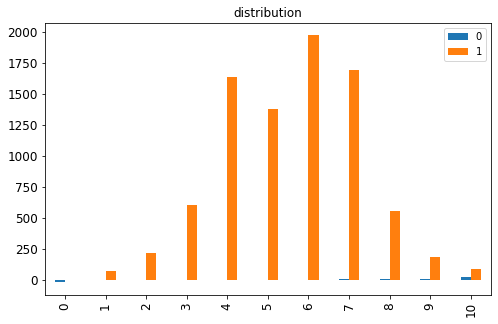

In [513]:
df.plot(kind='bar', title ="distribution", figsize=(8, 5), legend=True, fontsize=12)

<AxesSubplot:title={'center':'distribution'}>

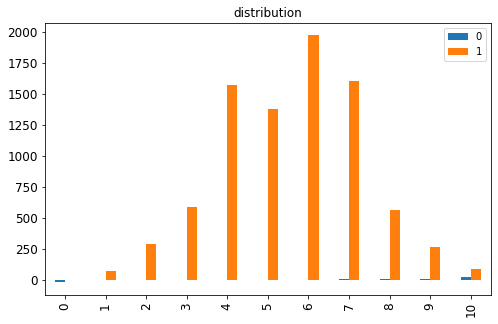

In [665]:
# bin =[-20,-5,-3,-1.9,-0.8, 0, 0.8, 1.9, 3, 5, 20]
df.plot(kind='bar', title ="distribution", figsize=(8, 5), legend=True, fontsize=12)

<AxesSubplot:title={'center':'distribution'}>

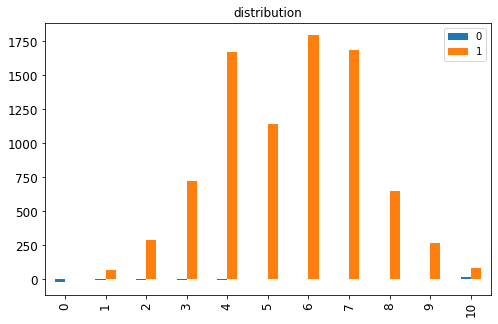

In [679]:
# bin =[-20,-5,-3,-1.8,-0.7, 0, 0.7, 1.8, 3, 5, 20]
df.plot(kind='bar', title ="distribution", figsize=(8, 5), legend=True, fontsize=12)

In [464]:
def get_freq(row):
    bin_idx=np.arange(12)
    nz=np.zeros(12)
    bin_base=np.vstack((bin_idx,nz)).T
    uniqueValues, occurCount = np.unique(row, return_counts=True)
#     bin_base[]
    res=np.asarray((uniqueValues, occurCount)).T
    bin_base[res[:,0].tolist(),1]=res[:,1]
    return bin_base

In [386]:
start=dt.datetime.now()
uniqueValues, occurCount = np.unique(r, return_counts=True)
# listOfUniqueValues = zip(uniqueValues, occurCount)
# res=
np.asarray((uniqueValues, counts)).T
# print (dt.datetime.now()-start)

array([[ 2,  1],
       [ 4,  3],
       [ 5,  1],
       [ 9,  3],
       [10,  1],
       [13,  1]], dtype=int64)

In [395]:
uniqueValues, occurCount = np.unique(r, return_counts=True)
uniqueValues

array([ 2,  4,  5,  9, 10, 13], dtype=int64)

In [396]:
occurCount

array([1, 3, 1, 3, 1, 1], dtype=int64)

In [397]:
np.asarray((uniqueValues, counts)).T

array([[ 2,  1],
       [ 4,  3],
       [ 5,  1],
       [ 9,  3],
       [10,  1],
       [13,  1]], dtype=int64)

In [392]:
uniqueValues, occurCount = np.unique(dd[0,:], return_counts=True)
uniqueValues

array([ 3,  4,  5,  7, 11], dtype=int64)

In [398]:
occurCount

array([1, 3, 1, 3, 1, 1], dtype=int64)

In [393]:
np.asarray((uniqueValues, counts)).T

<ipython-input-393-74f6b8a86a48>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray((uniqueValues, counts)).T


array([array([ 3,  4,  5,  7, 11], dtype=int64),
       array([1, 3, 1, 3, 1, 1], dtype=int64)], dtype=object)

In [274]:
import datetime as dt

In [299]:
start=dt.datetime.now()
y=np.bincount(r)
ii = np.nonzero(y)[0]
res = np.vstack((ii,y[ii])).T
print (dt.datetime.now()-start)

0:00:00


datetime.datetime(2023, 2, 18, 22, 32, 20, 958668)

0:00:00


In [283]:
res

array([[ 2,  1],
       [ 4,  3],
       [ 5,  1],
       [ 9,  3],
       [10,  1],
       [13,  1]], dtype=int64)

In [287]:
bin_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [250]:
np.unique(bin_ind[0,:],return_counts=True)

(array([ 2,  4,  5,  9, 10, 13], dtype=int64),
 array([1, 3, 1, 3, 1, 1], dtype=int64))

In [251]:
np.unique(bin_ind[1,:],return_counts=True)

(array([ 2,  4,  5,  9, 10, 11], dtype=int64),
 array([1, 3, 1, 3, 1, 1], dtype=int64))

In [260]:
values, counts = np.unique(r,return_counts=True,axis=1)

In [261]:
np.repeat(values, counts)

array([ 2,  4,  4,  4,  5,  9,  9,  9, 10, 13], dtype=int64)

In [242]:
np.unique(bin_ind,return_counts=True,axis=1)[0][0,:]

array([ 2,  4,  4,  4,  5,  9,  9,  9, 10, 13], dtype=int64)

In [234]:
set(r)

{2, 4, 5, 9, 10, 13}

In [221]:
tt=  [1100, 4.5, 5, 0,  1, -1, -5, 990, 34]

In [222]:
np.digitize(tt,bin)

array([13, 11, 12,  7,  9,  5,  2, 13, 12], dtype=int64)

In [196]:
# x = np.array([0.2, 6.4, 3.0, 1.6,5.5, 7.2,1.5])
# bins = np.array([0.0, 1.0, 2.5, 4.0, 10.0])
# # inds = 
# np.digitize(x, bins,right=True)

array([1, 4, 3, 2, 4, 4, 2], dtype=int64)

In [180]:
np.digitize(rr[1,:]*)

In [155]:
np.split(rr[0,:]*10, pct_bin)

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([  nan, -12.9,  10.8, -10.8,  12.9]),
 array([], dtype=float64),
 array([  nan, -12.9,  10.8, -10.8,  12.9]),
 array([-25.8,  10.8, -10.8,  -8.6,  17.3]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

In [993]:
base.query('ma1>ma2>ma3')

,time,open,close,high,low,volume,vol_prev,c_prev,ma1,ma2,...,valley2,peak2,valley3,peak3,price_pos,min_bias,huicai,min_bias13,min_bias46,min_bias79
14,2022/06/08-21:50,4651,4661,4662,4648,725,383.0,4650.0,4649.968251,4647.183369,...,6,14,6,14,1,2.367,False,2.367,3.096,3.031
15,2022/06/08-21:55,4661,4661,4667,4659,873,725.0,4661.0,4652.419751,4648.808855,...,7,15,7,15,1,1.841,False,1.841,2.964,3.020
16,2022/06/08-22:00,4661,4666,4668,4659,462,873.0,4661.0,4655.437584,4650.831342,...,8,16,8,16,1,2.264,False,2.264,3.788,4.053
17,2022/06/08-22:05,4666,4667,4668,4658,856,462.0,4666.0,4658.007010,4652.733537,...,9,17,9,17,1,1.927,False,1.927,3.759,4.200
18,2022/06/08-22:10,4668,4663,4669,4662,580,856.0,4667.0,4659.116563,4653.941356,...,10,18,10,18,1,0.833,False,0.833,2.729,3.294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,2022/12/02-14:55,3788,3790,3792,3784,13603,6835.0,3788.0,3785.841179,3784.828561,...,87,112,149,244,1,1.097,False,1.097,2.401,6.274
8374,2022/12/02-15:00,3791,3784,3791,3782,10710,13603.0,3790.0,3785.432028,3784.731083,...,88,113,150,245,2,-0.193,True,-0.193,0.770,4.626
8375,2022/12/05-21:05,3794,3787,3796,3782,36142,10710.0,3784.0,3785.780466,3784.998014,...,89,114,151,246,1,0.322,True,0.322,1.467,5.330
8398,2022/12/05-23:00,3784,3789,3790,3783,11073,6952.0,3783.0,3779.757582,3777.000576,...,112,137,174,269,1,2.439,False,2.439,3.332,5.307


In [1041]:
ntest= get_price_stage(bias,df_ma)

In [1020]:
%time base[['price_in_ma','price_in_ma_cnt']]=get_price_stage(bias,df_ma)

Wall time: 21 ms


In [1034]:
np.all(df_ma.values>0,axis=1)

array([False, False, False, ..., False,  True,  True])

In [1084]:
%time np.setdiff1d(final[:,0],c)

Wall time: 431 ms


array([1, 3, 4, ..., 8397, 8398, 8399], dtype=object)

In [1085]:
%time np.in1d(final[:,0],c)

Wall time: 450 ms


array([ True, False,  True, ..., False, False, False])

In [1137]:
final[np.in1d(final[:,1],np.array(None))]

array([], shape=(0, 3), dtype=object)

In [1163]:
# final[final[:,1] == np.array(None)]
np.intersect1d(final[final[:,2] == 0][:,0],c)

array([], dtype=object)

In [1165]:
np.all(df_ma.values>0,axis=1)

array([False, False, False, ..., False,  True,  True])

In [1154]:
final[:,2][:3]==1

array([False, False,  True])

In [1119]:
np.in1d(final[:,1],np.asarray(None))

array([False, False, False, ..., False, False, False])

In [1158]:
final

array([[0, array([0, 1, 2, 3, 4, 5], dtype=int64), 6],
       [1, None, 0.0],
       [2, array([0], dtype=int64), 1],
       ...,
       [8397, None, 0.0],
       [8398, None, 0.0],
       [8399, None, 0.0]], dtype=object)

In [1059]:
np.nanp

array([[   0],
       [   1],
       [   2],
       ...,
       [8397],
       [8398],
       [8399]])

In [998]:
arr_comb= np.absolute(arr_bias)+np.absolute(arr_bias2)
df_ma_abs = np.absolute(df_ma.values)

In [1000]:
%time check = np.round((arr_comb[:,:-1] - df_ma_abs),decimals=2)

Wall time: 1e+03 µs


In [1003]:
%time b = np.array(np.where(check == 0))

Wall time: 1.01 ms


In [1004]:
%time a = np.transpose(b)

Wall time: 1.01 ms


In [1005]:
%time overlap_count=np.unique(a[:, 0], return_counts=True)

Wall time: 965 µs


In [1006]:
%time b=np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])

Wall time: 6.96 ms


In [1008]:
c=overlap_count[0]
index=np.arange(8400)

Wall time: 0 ns


In [1010]:
index.shape=(8400,1) #创建和外部df一样的dim
obj_arr=new = np.empty((8400,1), dtype=object)

In [1011]:
%time obj_arr_2d=np.hstack((index,obj_arr))

Wall time: 0 ns


In [1012]:
%time obj_arr_2d[c.tolist(),1]=b

Wall time: 2 ms


In [1013]:
temp=np.zeros(8400)
temp.shape=(8400,1)

In [1014]:
%time final=np.hstack((obj_arr_2d,temp))

Wall time: 963 µs


In [1015]:
%time final[c.tolist(),2]=overlap_count[1]

Wall time: 0 ns


In [952]:
np.hstack((ntest[:,0],mm[:,2]))

array([0, 2, 9, ..., array([1, 2], dtype=int64),
       array([1, 2], dtype=int64), array([1, 2], dtype=int64)],
      dtype=object)

In [850]:
np.dstack((ntest[0],ntest[1]))

array([[[   0,    6],
        [   2,    1],
        [   9,    1],
        ...,
        [8391,    2],
        [8392,    2],
        [8393,    2]]], dtype=int64)

In [772]:
bias.shape[0]

8400

In [805]:
nz = np.zeros((8400,3))

In [806]:
nz[mm[:,0].tolist(),0]=mm[:,1] 

In [808]:
nz[mm[:,0].tolist(),0]
# =mm[:,2]

array([6., 1., 1., ..., 2., 2., 2.])

In [844]:
nz[:,2]

array([0., 0., 0., ..., 0., 0., 0.])

In [815]:
new_ind=np.arange(8400)
new_ind.shape=(8400,1)

In [818]:
new_ind

array([[   0],
       [   1],
       [   2],
       ...,
       [8397],
       [8398],
       [8399]])

In [820]:
new = np.empty((8400,1), dtype=object)
# new=mm[:,2]

In [840]:
newi = np.hstack((new_ind,new))

In [841]:
newi

array([[0, None],
       [1, None],
       [2, None],
       ...,
       [8397, None],
       [8398, None],
       [8399, None]], dtype=object)

In [842]:
newi[mm[:,0].tolist(),1]=mm[:,2]

In [843]:
newi

array([[0, array([0, 1, 2, 3, 4, 5], dtype=int64)],
       [1, None],
       [2, array([0], dtype=int64)],
       ...,
       [8397, None],
       [8398, None],
       [8399, None]], dtype=object)

In [837]:
newi[mm[:,0].tolist(),]
# =mm[:,2]

array([[0, None],
       [2, None],
       [9, None],
       ...,
       [8391, None],
       [8392, None],
       [8393, None]], dtype=object)

In [782]:
nz[mm[:,0].tolist(),1].shape

(4623,)

In [785]:
mm[:,2]

array([array([0, 1, 2, 3, 4, 5], dtype=int64), array([0], dtype=int64),
       array([0], dtype=int64), ..., array([1, 2], dtype=int64),
       array([1, 2], dtype=int64), array([1, 2], dtype=int64)],
      dtype=object)

In [803]:
mm= get_price_stage(bias,df_ma)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [890]:
mm

array([[0, 6, array([0, 1, 2, 3, 4, 5], dtype=int64)],
       [2, 1, array([0], dtype=int64)],
       [9, 1, array([0], dtype=int64)],
       ...,
       [8391, 2, array([1, 2], dtype=int64)],
       [8392, 2, array([1, 2], dtype=int64)],
       [8393, 2, array([1, 2], dtype=int64)]], dtype=object)

In [964]:
x = np.arange(8400*3)

In [965]:
x.shape=(3,8400)

In [966]:
y=np.transpose(x)

In [967]:
y

array([[    0,  8400, 16800],
       [    1,  8401, 16801],
       [    2,  8402, 16802],
       ...,
       [ 8397, 16797, 25197],
       [ 8398, 16798, 25198],
       [ 8399, 16799, 25199]])

In [759]:
mm

array([[0, 6, array([0, 1, 2, 3, 4, 5], dtype=int64)],
       [2, 1, array([0], dtype=int64)],
       [9, 1, array([0], dtype=int64)],
       ...,
       [8391, 2, array([1, 2], dtype=int64)],
       [8392, 2, array([1, 2], dtype=int64)],
       [8393, 2, array([1, 2], dtype=int64)]], dtype=object)

In [768]:
y[mm[:,0].tolist(),1]=mm[:,1]

In [ ]:
numpy.array( Array ,dtype = Common_DataType );

In [799]:
# y[mm[:,0].tolist(),2]=
mm[:,2]

array([array([0, 1, 2, 3, 4, 5], dtype=int64), array([0], dtype=int64),
       list([0, 1, 2, 3, 4, 5]), ..., array([1, 2], dtype=int64),
       array([1, 2], dtype=int64), array([1, 2], dtype=int64)],
      dtype=object)

In [801]:
np.hstack()

array([array([0, 1, 2, 3, 4, 5], dtype=int64), array([0], dtype=int64),
       list([0, 1, 2, 3, 4, 5]), ..., array([1, 2], dtype=int64),
       array([1, 2], dtype=int64), array([1, 2], dtype=int64)],
      dtype=object)

In [754]:
a = np.ma.arange(3)
a

masked_array(data=[0, 1, 2],
             mask=False,
       fill_value=999999)

In [755]:
a[1] = np.ma.masked
a

masked_array(data=[0, --, 2],
             mask=[False,  True, False],
       fill_value=999999)

In [756]:
b = np.arange(2, 5)
b

array([2, 3, 4])

In [745]:
y[:,[1,2]]=0

In [748]:
np.concatenate((y, mm), axis=1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 8400 and the array at index 1 has size 4623

In [703]:
tt = np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])

In [705]:
len(tt)

4623

In [701]:
np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1])

[array([], dtype=int64),
 array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([3], dtype=int64),
 array([2], dtype=

In [680]:
get_price_stage(bias,df_ma)

array([[   0,    6],
       [   2,    1],
       [   9,    1],
       ...,
       [8391,    2],
       [8392,    2],
       [8393,    2]], dtype=int64)

In [634]:
test = [res[0][0],res[0][1],res[1]]

In [636]:
np.transpose(test)

array([[0, 6, array([0, 1, 2, 3, 4, 5], dtype=int64)],
       [2, 1, array([0], dtype=int64)],
       [9, 1, array([0], dtype=int64)],
       ...,
       [8391, 2, array([1, 2], dtype=int64)],
       [8392, 2, array([1, 2], dtype=int64)],
       [8393, 2, array([1, 2], dtype=int64)]], dtype=object)

In [632]:
res[0][1]

array([6, 1, 1, ..., 2, 2, 2], dtype=int64)

In [589]:
stage[0]

array([   0,    2,    9, ..., 8391, 8392, 8393], dtype=int64)

In [526]:
stage[1]

array([6, 1, 1, ..., 2, 2, 2], dtype=int64)

In [535]:
te [stage[0],stage[1],get_price_stage(bias,df_ma)[0][1]]

Wall time: 9.01 ms


[array([   0,    2,    9, ..., 8391, 8392, 8393], dtype=int64),
 array([6, 1, 1, ..., 2, 2, 2], dtype=int64),
 [array([0, 1, 2, 3, 4, 5], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([0, 1], dtype=int64),
  array(

In [536]:
%time np.vstack((test[0],test[1],get_price_stage(bias,df_ma)[0][1]))

Wall time: 8.01 ms


array([[0, 2, 9, ..., 8391, 8392, 8393],
       [6, 1, 1, ..., 2, 2, 2],
       [array([0, 1, 2, 3, 4, 5], dtype=int64), array([0], dtype=int64),
        array([0], dtype=int64), ..., array([1, 2], dtype=int64),
        array([1, 2], dtype=int64), array([1, 2], dtype=int64)]],
      dtype=object)

In [580]:
t_test = np.transpose(test)

In [581]:
t_test

array([[   0,    6],
       [   2,    1],
       [   9,    1],
       ...,
       [8391,    2],
       [8392,    2],
       [8393,    2]], dtype=int64)

In [523]:
get_price_stage(bias,df_ma)[0][1]

[array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([3], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype

In [458]:
bias=base[['bias1','bias2','bias3','bias5','bias6','bias8','bias9']]
df_ma = base[['df_ma12','df_ma23','df_ma45','df_ma56','df_ma78','df_ma89']]

In [459]:
arr_bias=bias.values

In [460]:
arr_bias2=arr_bias[:,[1,2,3,4,5,6,0]]

In [461]:
arr_comb= np.absolute(arr_bias)+np.absolute(arr_bias2)

In [463]:
df_ma_abs = np.absolute(df_ma.values)

In [464]:
check = np.round((arr_comb[:,:-1] - df_ma_abs),decimals=2)

In [566]:
b = np.array(np.where(check == 0))

In [568]:
np.array(b)

array([[   0,    0,    0, ..., 8392, 8393, 8393],
       [   0,    1,    2, ...,    2,    1,    2]], dtype=int64)

In [569]:
a = np.transpose(b)

In [570]:
a

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [8392,    2],
       [8393,    1],
       [8393,    2]], dtype=int64)

In [571]:
c=np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])

In [575]:
d=np.array(c,dtype=object)

In [578]:
d.shape

(4623,)

In [579]:
a.shape

(5919, 2)

In [577]:
np.hstack((a,np.transpose(d)))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [687]:
np.unique(a[:, 0], return_counts=True)[1][1:]

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [477]:
x=np.unique(a[:, 0])

In [478]:
y=np.unique(a[:, 0], return_counts=True)[1][1:]

In [688]:
# z=
np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])

[array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([3], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype

In [499]:
y

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [498]:
z

[array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([3], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype

In [447]:
np.unique(a[:, 0], return_counts=True)[1][1:]

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [449]:
final=[np.unique(a[:, 0]),np.unique(a[:, 0], return_counts=True)[1][1:],np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])]

In [452]:
np.hstack(np.unique(a[:, 0]),np.unique(a[:, 0], return_counts=True)[1][1:],np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:]))

TypeError: _vhstack_dispatcher() takes 1 positional argument but 3 were given

In [457]:
np.unique(a[:, 0])

array([1, 2, 3])

In [451]:
a=

[array([   0,    2,    9, ..., 8391, 8392, 8393], dtype=int64),
 array([1, 1, 1, ..., 2, 2, 2], dtype=int64),
 [array([0, 1, 2, 3, 4, 5], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([0, 1], dtype=int64),
  array(

In [450]:
np.transpose(final)

array([array([   0,    2,    9, ..., 8391, 8392, 8393], dtype=int64),
       array([1, 1, 1, ..., 2, 2, 2], dtype=int64),
       list([array([0, 1, 2, 3, 4, 5], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([2], dtype=int64), array([2], dtype=int64), array([2], dtype=int64), array([2], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([2], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([2], dtype=int64), array([2], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([2], dtype=in

In [445]:
[np.unique(a[:, 0]),np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])]

[array([   0,    2,    9, ..., 8391, 8392, 8393], dtype=int64),
 [array([0, 1, 2, 3, 4, 5], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([0, 1], dtype=int64),
  array([0, 1], dtype=int64),
  array([2], dtype=int64

In [444]:
final=[np.unique(a[:, 0]), np.unique(a[:, 0], return_index=True)[1][1:])]

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-444-24d9b02703ba>, line 1)

In [441]:
result = np.transpose(final)

In [442]:
result[:,1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
final=[np.unique(a[:, 0]),np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])]

In [418]:
a

array([[0.59342419, 0.10972113, 0.3968218 , 0.40463054, 0.92211832,
        0.48132383, 0.44161963, 0.16472414, 0.58855879, 0.6101088 ],
       [0.98401722, 0.91231656, 0.80127098, 0.0576978 , 0.40898751,
        0.41360413, 0.6609084 , 0.99512519, 0.46057903, 0.52648882],
       [0.33517753, 0.76276762, 0.46646208, 0.77953201, 0.27580734,
        0.42588244, 0.00548293, 0.18538807, 0.03897664, 0.06781303],
       [0.90783969, 0.6847499 , 0.50525182, 0.14398931, 0.78218175,
        0.27277545, 0.99300815, 0.06820337, 0.82505752, 0.68893283],
       [0.2804045 , 0.09080233, 0.08700098, 0.42893987, 0.08206838,
        0.59602951, 0.23231069, 0.97492137, 0.24023959, 0.81876398],
       [0.25194841, 0.69611267, 0.75942637, 0.79791706, 0.85691991,
        0.74375207, 0.4353372 , 0.23549236, 0.76800746, 0.99674941],
       [0.94859592, 0.72252761, 0.78860236, 0.68037916, 0.61580158,
        0.7246127 , 0.59491076, 0.81780066, 0.82235116, 0.02974382],
       [0.47484223, 0.74729774, 0.1503629

In [414]:
ll=list(range(1,8,1))

In [416]:
ll.append(0)

In [417]:
ll

[1, 2, 3, 4, 5, 6, 7, 0]

In [387]:
bias=base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']]

In [222]:
tt2=base[['bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9','bias1']]

In [392]:
arr=tt.values

In [410]:
arr[:,[1,2,3,4,5,6,7,8,0]]

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [-1.141, -1.214, -1.214, ..., -1.283, -1.288, -1.006],
       [-0.056, -0.129, -0.129, ..., -0.204, -0.209,  0.056],
       ...,
       [ 2.009,  1.967,  1.967, ...,  5.954, 10.493,  1.555],
       [ 3.167,  3.332,  3.332, ...,  7.469, 12.013,  2.439],
       [ 2.794,  3.13 ,  3.13 , ...,  7.411, 11.967,  1.897]])

In [395]:
N = 10
a = np.random.rand(N,N)

In [396]:
a

array([[0.59342419, 0.10972113, 0.3968218 , 0.40463054, 0.92211832,
        0.48132383, 0.44161963, 0.16472414, 0.58855879, 0.6101088 ],
       [0.98401722, 0.91231656, 0.80127098, 0.0576978 , 0.40898751,
        0.41360413, 0.6609084 , 0.99512519, 0.46057903, 0.52648882],
       [0.33517753, 0.76276762, 0.46646208, 0.77953201, 0.27580734,
        0.42588244, 0.00548293, 0.18538807, 0.03897664, 0.06781303],
       [0.90783969, 0.6847499 , 0.50525182, 0.14398931, 0.78218175,
        0.27277545, 0.99300815, 0.06820337, 0.82505752, 0.68893283],
       [0.2804045 , 0.09080233, 0.08700098, 0.42893987, 0.08206838,
        0.59602951, 0.23231069, 0.97492137, 0.24023959, 0.81876398],
       [0.25194841, 0.69611267, 0.75942637, 0.79791706, 0.85691991,
        0.74375207, 0.4353372 , 0.23549236, 0.76800746, 0.99674941],
       [0.94859592, 0.72252761, 0.78860236, 0.68037916, 0.61580158,
        0.7246127 , 0.59491076, 0.81780066, 0.82235116, 0.02974382],
       [0.47484223, 0.74729774, 0.1503629

In [397]:
b = np.zeros((N,N+1))

In [398]:
b

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [399]:
b[:,:-1] = a

In [400]:
b

array([[0.59342419, 0.10972113, 0.3968218 , 0.40463054, 0.92211832,
        0.48132383, 0.44161963, 0.16472414, 0.58855879, 0.6101088 ,
        0.        ],
       [0.98401722, 0.91231656, 0.80127098, 0.0576978 , 0.40898751,
        0.41360413, 0.6609084 , 0.99512519, 0.46057903, 0.52648882,
        0.        ],
       [0.33517753, 0.76276762, 0.46646208, 0.77953201, 0.27580734,
        0.42588244, 0.00548293, 0.18538807, 0.03897664, 0.06781303,
        0.        ],
       [0.90783969, 0.6847499 , 0.50525182, 0.14398931, 0.78218175,
        0.27277545, 0.99300815, 0.06820337, 0.82505752, 0.68893283,
        0.        ],
       [0.2804045 , 0.09080233, 0.08700098, 0.42893987, 0.08206838,
        0.59602951, 0.23231069, 0.97492137, 0.24023959, 0.81876398,
        0.        ],
       [0.25194841, 0.69611267, 0.75942637, 0.79791706, 0.85691991,
        0.74375207, 0.4353372 , 0.23549236, 0.76800746, 0.99674941,
        0.        ],
       [0.94859592, 0.72252761, 0.78860236, 0.68037916, 0.

In [ ]:
N = 10
a = np.random.rand(N,N)
b = np.zeros((N,N+1))
b[:,:-1] = a

In [224]:
result = np.absolute(tt.values)+np.absolute(tt2.values)

In [226]:
df_bias = result[:,[0,1,3,4,6,7]]

In [275]:
# df_ma = base[['df_ma12','df_ma23','df_ma34','df_ma45','df_ma56','df_ma67','df_ma78','df_ma89']]
df_ma = base[['df_ma12','df_ma23','df_ma45','df_ma56','df_ma78','df_ma89']]
# 如果临近的2个bias相加等于df_ma 则表现价格位于2条ma之间
# bias1 和 bias9 相减 对于df_ma19

In [276]:
df_abs = np.absolute(df_ma.values)

In [230]:
check = df_bias - df_abs

In [241]:
final = np.round(check,decimals=2)

In [271]:
final[8392:8393,]

array([[0.51, 0.  , 0.  , 0.14, 2.79, 7.03]])

In [249]:
len(np.where(final == 0)[1])

5919

In [268]:
np.where(final == 0)[0]

array([   0,    0,    0, ..., 8392, 8393, 8393], dtype=int64)

In [259]:
np.where(final == 0)[0][:10]

array([ 0,  0,  0,  0,  0,  0,  2,  9, 37, 38], dtype=int64)

In [366]:
b = np.array(np.where(final == 0))

In [367]:
# len(set(np.where(final == 0)[0]))
# np.where(final == 0)[1].max()

In [368]:
b

array([[   0,    0,    0, ..., 8392, 8393, 8393],
       [   0,    1,    2, ...,    2,    1,    2]], dtype=int64)

In [369]:
a=np.transpose(b)

In [370]:
np.split(a[:,1], np.unique(a[:, 0], return_index=True)[1][1:])

[array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([3], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype

In [356]:
np.unique(a[:, 0], return_index=True)

(array([   0,    2,    9, ..., 8391, 8392, 8393], dtype=int64),
 array([   0,    6,    7, ..., 5913, 5915, 5917], dtype=int64))

In [347]:
np.unique(a[:, 0])

array([   0,    2,    9, ..., 8391, 8392, 8393], dtype=int64)

In [379]:
np.unique(a[:, 0], return_counts=True)[1][1:]

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [386]:
np.unique(a[:, 0], return_counts=True)[1][1:]

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [349]:
new=[np.unique(a[:, 0]),np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])]

In [382]:
new2

[array([   0,    2,    9, ..., 8391, 8392, 8393], dtype=int64),
 [array([], dtype=int64),
  array([0, 1, 2, 3, 4, 5], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([0], dtype=int64),
  array([0], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([1], dtype=int64),
  array([2], dtype=int64),
  array([2], dtype=int64),
  array([0, 1], dtype=int64),
  array([0, 1], dtype=int64)

In [378]:
pd.DataFrame(np.transpose(new)).set_index(0).rename(columns={1:'ma_num'})

d:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


,ma_num
0,
0,"[0, 1, 2, 3, 4, 5]"
2,[0]
9,[0]
37,[0]
38,[0]
...,...
8389,[4]
8390,"[1, 3]"
8391,"[1, 2]"


In [320]:
def groupby(X): 
    X = np.asarray(X) 
    x_uniques = np.unique(X) 
    return {xi:X[X==xi] for xi in x_uniques} 

In [294]:
a = a[a[:, 0].argsort()]  # 按照user_id排序（排序是使用np.split进行分组的前提）
a = np.split(a, np.unique(a[:, 0], return_index=True)[1][1:])  # 按照user_id分组
a = np.array([tmp[tmp[:, 1].argsort()[-1], :1] for tmp in a])  # 取分组下分值最高的item_id
a = a[a[:, 1].argsort()]
item_ids, ind = np.unique(a[:, 1], return_index=True)
a = np.split(a[:, 0], ind[1:])
result = dict(zip(item_ids, a))


TypeError: list indices must be integers or slices, not tuple

In [293]:
result

{1: array([0], dtype=int64)}

In [232]:
np.round(check,decimals=2)[-22:-19]

array([[ 1.72,  2.13, -0.  ,  1.03,  4.71,  9.26],
       [ 1.33,  2.  ,  0.  ,  1.  ,  4.64,  9.19],
       [ 3.1 ,  4.37,  1.6 , -0.  ,  1.96,  6.5 ]])

In [234]:
base.iloc[-6:,:].filter(['close','ma1','ma2','ma3','ma4','ma5','ma6','ma7','ma8','ma9',])
# .filter(['close','ma1','ma2','ma13,'ma4','ma5','ma6','ma7','ma8','ma9',])

,close,ma1,ma2,ma3,ma4,ma5,ma6,ma7,ma8,ma9
8394,3779,3773.026862,3773.057603,3774.553782,3774.553782,3772.956205,3768.008936,3768.008936,3760.006452,3742.866529
8395,3778,3774.132004,3773.639061,3774.762644,3774.762644,3773.111398,3768.163836,3768.163836,3760.146480,3743.003501
8396,3780,3775.436003,3774.387407,3775.080060,3775.080060,3773.323355,3768.347343,3768.347343,3760.300982,3743.147737
8397,3783,3777.116891,3775.400653,3775.560056,3775.560056,3773.621098,3768.574516,3768.574516,3760.477628,3743.303106
8398,3789,3779.757582,3777.000576,3776.374598,3776.374598,3774.094295,3768.891190,3768.891190,3760.699592,3743.481262
8399,3789,3781.811453,3778.412273,3777.139774,3777.139774,3774.552932,3769.202954,3769.202954,3760.919829,3743.658723


In [218]:
base.iloc[-22:-21,:].filter(['bias4','bias5','df_ma45'])

,bias4,bias5,df_ma45
8378,-1.06,0.51,1.58


In [260]:
# %time 
# base.iloc[:10,:].apply(lambda x:get_price_stage(x),axis=1)
%time base[['price_pos','min_bias']].apply(lambda x:get_price_stage(x),axis=1)

Wall time: 2.34 s


,0
0,True
1,False
2,True
3,False
4,True
...,...
8395,False
8396,False
8397,False
8398,False


In [179]:
base[['min_bias','price_pos']].query('abs(min_bias) <= 0.5')

,min_bias,price_pos
0,0.00,1
2,0.06,1
4,0.01,9
6,-0.49,1
9,0.08,1
...,...,...
8389,-0.40,6
8390,0.06,2
8391,0.08,5
8392,0.07,5


In [123]:
x[np.arange(len(x)), np.abs(x).argmin(axis=1)]

array([ 0.  , -1.  ,  0.06, ...,  1.56,  2.45,  1.9 ])

In [77]:
one = test.iloc[0]

In [78]:
one

bias1        0.0
bias2        0.0
bias3        0.0
bias4        0.0
bias5        0.0
bias6        0.0
bias7        0.0
bias8        0.0
bias9        0.0
price_pos    1.0
Name: 0, dtype: float64

In [79]:
one[-1]

1.0

In [80]:
one[1]

0.0

In [81]:
one[one[-1]]

KeyError: 1.0

In [75]:
test

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [60]:
get_min_bias(base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9','price_pos']])

KeyError: 1.0

In [95]:
base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9','price_pos']].query("price_pos == 1")

,bias1,bias2,bias3,bias4,bias5,bias6,bias7,bias8,bias9,price_pos
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
1,-1.00,-1.11,-1.17,-1.17,-1.22,-1.25,-1.25,-1.26,-1.27,1
3,-0.79,-0.95,-1.06,-1.06,-1.14,-1.19,-1.19,-1.23,-1.25,1
5,-1.71,-1.96,-2.16,-2.16,-2.30,-2.40,-2.40,-2.47,-2.51,1
6,-0.49,-0.76,-0.98,-0.98,-1.16,-1.28,-1.28,-1.36,-1.41,1
...,...,...,...,...,...,...,...,...,...,...
8384,-0.17,-0.60,-1.01,-1.01,-0.99,-0.30,-0.30,0.80,1.99,1
8396,1.21,1.47,1.42,1.42,1.30,1.57,1.57,2.33,3.37,1
8397,1.56,1.94,2.02,2.02,1.98,2.28,2.28,3.06,4.11,1
8398,2.45,3.03,3.28,3.28,3.36,3.73,3.73,4.55,5.62,1


In [68]:
test =  base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']]

In [62]:
baseC = base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']].copy()

In [45]:
%time get_price_pos(base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']])

Wall time: 2.37 ms


array([1, 9, 9, ..., 1, 1, 1], dtype=int64)

In [84]:
%time np.argmin(base[['bias1','bias2','bias3','bias4','bias5','bias6','bias7','bias8','bias9']].values,axis=1)+1

Wall time: 2.49 ms


array([1, 9, 9, ..., 1, 1, 1], dtype=int64)

In [81]:
%time get_price_pos(test)

Wall time: 7.09 ms


array([1, 1, 2, ..., 1, 1, 1], dtype=int64)

In [ ]:
def get_signal(base):
    # 均线态势  kl13_ml_kt  kl13_ml_dt kl14_ml_kt kl14_ml_dt 
    
    # 价格位置  get_price_pos
    
    # 价格态势  
    
    # K线形态 
    
    
    
    # K线态势 mab: ma body 
    
    # 量能形态
    
    # 量价形态 单阴线放量见底 单阳线放量见顶  
    
    

In [19]:
# a = [3, 5, 1,6,10,9,9,19,20]
# b = np.argsort(a)
# print("a排序为：", end='')
# print(b)

def get_top1_idx(arr):
    sorted_arr = np.argsort(arr)
    return sorted_arr[-1]

In [164]:
# %time pivots = 
%time peak_valley_pivots(klines.close, 0.03, -0.03)

Wall time: 1.02 ms


array([-1,  0,  0, ...,  0,  0, -1])

In [165]:
klines['zig']=peak_valley_pivots(klines.close, 0.03, -0.03)

In [157]:
def plot_pivots(X, pivots):
    plt.xlim(0, len(X))
    plt.ylim(X.min()*0.99, X.max()*1.01)
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')

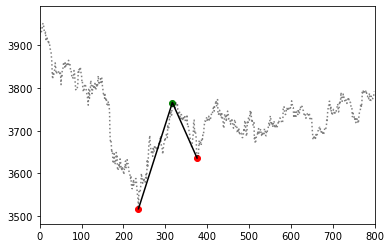

In [175]:
plot_pivots(klines.close[1700:2500], pivots[1700:2500])

In [136]:
get_top1_idx(base.volume[:10].values)

5

In [133]:
np.argsort(base.volume[:10].values)

array([0, 9, 3, 7, 8, 2, 1, 6, 4, 5], dtype=int64)

In [106]:
def get_top2(base ,n):
    vol_data=base.copy()
    vol_data.loc[:,('hhv_vol_'+str(n))] = hhv(vol_data.volume,n)
    vol_data.loc[:,('new_vol')] = vol_data.volume * (vol_data['hhv_vol_'+str(n)] != vol                                                                                                                                                                                                                                                                                                                                           _data.volume)
    vol_data.loc[:,('hhv_vol_' + str(n) + '_2')] = hhv(vol_data.new_vol,n)
#     return vol_data['hhv_vol_' + str(n) + '_2']
    return vol_data

In [110]:
vol_data = base[['volume']].copy()/
vol_data.loc[:,('hhv_vol_' + str(vs))] = hhv(vol_data.volume,vs)

In [112]:
vol_data

,volume,hhv_vol_12
0,882,NaN
1,1396,NaN
2,1248,NaN
3,988,NaN
4,1505,NaN
...,...,...
8395,6232,12261.0
8396,6585,12261.0
8397,6952,12261.0
8398,11073,12261.0


In [113]:
vol_data['hhv_vol_'+str(vs)] != vol_data.volume

0       True
1       True
2       True
3       True
4       True
        ... 
8395    True
8396    True
8397    True
8398    True
8399    True
Length: 8400, dtype: bool

In [114]:
# vol_data[:,('new_vol')] = 
vol_data.volume * (vol_data['hhv_vol_'+str(vs)] != vol_data.volume)

0         882
1        1396
2        1248
3         988
4        1505
        ...  
8395     6232
8396     6585
8397     6952
8398    11073
8399        0
Length: 8400, dtype: int64

In [99]:
hhv(base.volume,12)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
8395    12261.0
8396    12261.0
8397    12261.0
8398    12261.0
8399    11073.0
Name: volume, Length: 8400, dtype: float64

In [107]:
get_top2(base[['volume',]],vs)
# .query('new_vol==0')

TypeError: unhashable type: 'slice'

In [93]:
base[['volume','hhv_vol_'+str(vs)]]

,volume,hhv_vol_12
0,882,NaN
1,1396,NaN
2,1248,NaN
3,988,NaN
4,1505,NaN
...,...,...
8395,6232,12261.0
8396,6585,12261.0
8397,6952,12261.0
8398,11073,12261.0


In [77]:
hhv(base.volume,12)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
8395    12261.0
8396    12261.0
8397    12261.0
8398    12261.0
8399    11073.0
Name: volume, Length: 8400, dtype: float64

In [74]:
type(base[['volume']])

pandas.core.frame.DataFrame

In [65]:
base['hhv_vol_'+str(10)+'d']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
8395    12261.0
8396    12261.0
8397     6952.0
8398    11073.0
8399    11073.0
Name: hhv_vol_10d, Length: 8400, dtype: float64

In [69]:
base.columns

Index(['time', 'open', 'close', 'high', 'low', 'volume', 'vol_prev', 'c_prev',
       'ma1s', 'ma2s',
       ...
       'jl_1d', 'jl_tj', 'jl_2d', 'jl_3d', 'jl_1d_last_days',
       'jl_2d_last_days', 'jl_3d_last_days', 'hhv_vol_12', 'hhv_vol_46',
       'hhv_vol_120'],
      dtype='object', length=127)

In [126]:
base.volume[:10]

0     882
1    1396
2    1248
3     988
4    1505
5    4804
6    1487
7    1030
8    1204
9     986
Name: volume, dtype: int64

In [68]:
base[['bias1s','bias2s','bias3s','bias2m','bias3m','bias2l','bias3l']]

,bias1s,bias2s,bias3s,bias2m,bias3m,bias2l,bias3l
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-1.00,-1.11,-1.17,-1.22,-1.25,-1.26,-1.27
2,0.06,-0.03,-0.09,-0.13,-0.16,-0.18,-0.19
3,-0.79,-0.95,-1.06,-1.14,-1.19,-1.23,-1.25
4,0.39,0.30,0.21,0.14,0.09,0.06,0.04
...,...,...,...,...,...,...,...
8395,1.02,1.19,1.04,0.85,1.10,1.86,2.88
8396,1.21,1.47,1.42,1.30,1.57,2.33,3.37
8397,1.56,1.94,2.02,1.98,2.28,3.06,4.11
8398,2.45,3.03,3.28,3.36,3.73,4.55,5.62


In [22]:
# %time klines.volume.rolling(10,min_periods=3).apply(lambda x:x.nlargest(1).iloc[0])

In [ ]:
 klines.volume.max()

In [49]:
 klines.volume.rolling(10,min_periods=3).apply(lambda x:x.nlargest(1).iloc[0])[10:20]

10    4804.0
11    4804.0
12    4804.0
13    4804.0
14    4804.0
15    1487.0
16    1432.0
17    1432.0
18    1432.0
19    1432.0
Name: volume, dtype: float64

In [138]:
%time klines['hhv10'] = hhv(klines.volume,10)

Wall time: 3 ms


In [63]:
%time klines['vol1'] = klines.apply(lambda x:1 if x.volume==x.hhv10 else x.volume,axis=1)

Wall time: 178 ms


In [155]:
%time get_top2(klines)

Wall time: 1.97 ms


,time,open,close,high,low,volume,hhv10,hhv10_2
0,2022/06/07-14:40,4647,4647,4650,4644,882,NaN,NaN
1,2022/06/07-14:45,4647,4641,4650,4639,1396,NaN,NaN
2,2022/06/07-14:50,4641,4646,4647,4638,1248,NaN,NaN
3,2022/06/07-14:55,4645,4641,4645,4636,988,NaN,NaN
4,2022/06/07-15:00,4640,4647,4648,4639,1505,NaN,NaN
...,...,...,...,...,...,...,...,...
8395,2022/12/05-22:45,3779,3778,3782,3776,6232,12261.0,12261.0
8396,2022/12/05-22:50,3778,3780,3782,3776,6585,12261.0,12261.0
8397,2022/12/05-22:55,3780,3783,3784,3776,6952,6952.0,6585.0
8398,2022/12/05-23:00,3784,3789,3790,3783,11073,11073.0,6585.0


In [142]:
%time klines[klines.hhv10==klines.volume]

Wall time: 2.02 ms


,time,open,close,high,low,volume,hhv10
21,2022/06/08-22:25,4664,4675,4675,4664,1367,1367.0
28,2022/06/08-23:00,4687,4690,4693,4681,1730,1730.0
29,2022/06/08-09:05,4688,4682,4695,4682,2543,2543.0
39,2022/06/08-09:55,4688,4697,4704,4688,1803,1803.0
54,2022/06/08-11:25,4691,4716,4721,4690,2779,2779.0
...,...,...,...,...,...,...,...
8364,2022/12/02-14:10,3793,3784,3793,3781,12289,12289.0
8373,2022/12/02-14:55,3788,3790,3792,3784,13603,13603.0
8375,2022/12/05-21:05,3794,3787,3796,3782,36142,36142.0
8397,2022/12/05-22:55,3780,3783,3784,3776,6952,6952.0


In [33]:
%time hhv(klines.volume,10)

Wall time: 999 µs


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
8395    12261.0
8396    12261.0
8397     6952.0
8398    11073.0
8399    11073.0
Name: volume, Length: 8400, dtype: float64

In [30]:
klines.volume.rolling(10,min_periods=2).max()

0           NaN
1        1396.0
2        1396.0
3        1396.0
4        1505.0
         ...   
8395    12261.0
8396    12261.0
8397     6952.0
8398    11073.0
8399    11073.0
Name: volume, Length: 8400, dtype: float64

## 做空

In [65]:
initial_cash = 20000
positions = pd.DataFrame(index = rb_df.index)
portfolio = pd.DataFrame(index = rb_df.index)
positions['stock'] = rb_df['long']*4
portfolio['stock value'] = positions.multiply(rb_df['close'],axis=0)
order=positions.diff()
portfolio['cash'] = initial_cash - order.multiply(rb_df['close'],axis=0).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['stock value']
portfolio.tail()

,stock value,cash,total
time,,,
2022/11/14-22:45,0,19576.0,19576.0
2022/11/14-22:50,0,19576.0,19576.0
2022/11/14-22:55,0,19576.0,19576.0
2022/11/14-23:00,0,19576.0,19576.0
2022/11/14-09:05,0,19576.0,19576.0


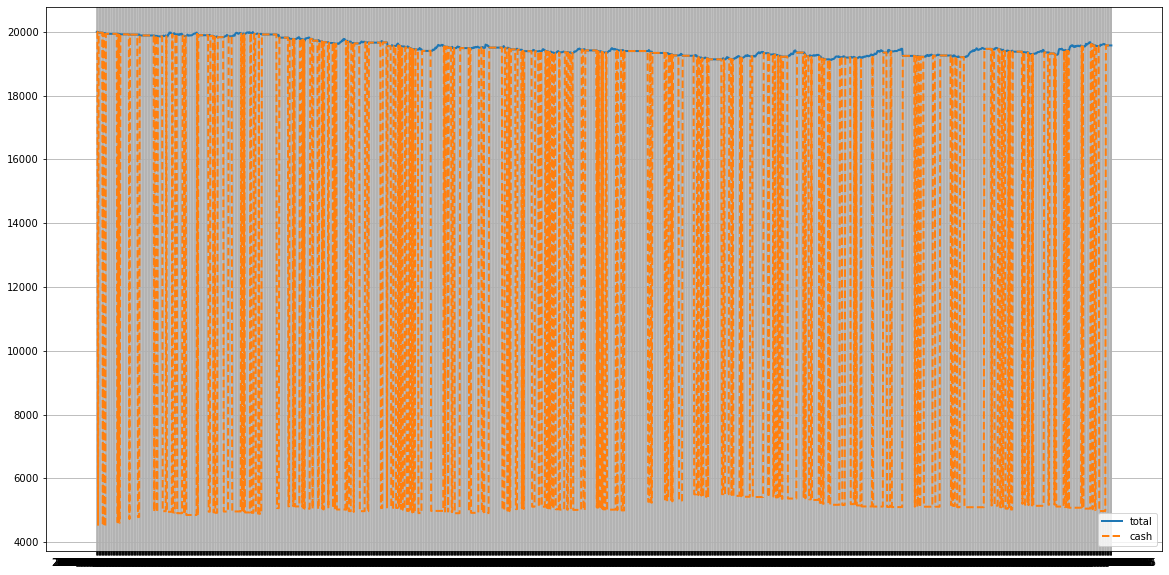

In [71]:
plt.figure(figsize=(20,10))
# 用实线画股价
# plt.plot(rb_df['close'],lw=2,label='price')
# plt.plot(rb_df['ma0'],lw=2,ls='--',label='ma0')
# plt.plot(rb_df['ma1'],lw=2,ls='-.',label='ma1')
# plt.scatter(portfolio.loc[strategy.order==1].index,
#             zgpa['close'][strategy.order==1],
#            marker='^',s=80,color='g',label='buy')
# plt.scatter(strategy.loc[strategy.order==-1].index,
#             zgpa['close'][strategy.order==1],
#            marker='v',s=80,color='g',label='sell')
plt.plot(portfolio['total'],lw=2,label='total')
# plt.plot(portfolio['cash'], lw=2, ls='--',label='cash')
plt.legend()
plt.grid()
plt.show()

In [72]:
initial_cash = 20000
positions = pd.DataFrame(index = rb_df.index)
portfolio = pd.DataFrame(index = rb_df.index)
positions['stock'] = rb_df['short']*4
portfolio['stock value'] = positions.multiply(rb_df['close'],axis=0)
order=positions.diff()
portfolio['cash'] = initial_cash - order.multiply(rb_df['close'],axis=0).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['stock value']
portfolio.tail()

,stock value,cash,total
time,,,
2022/11/14-22:45,-14596,34928.0,20332.0
2022/11/14-22:50,-14600,34928.0,20328.0
2022/11/14-22:55,-14592,34928.0,20336.0
2022/11/14-23:00,-14580,34928.0,20348.0
2022/11/14-09:05,-14580,34928.0,20348.0


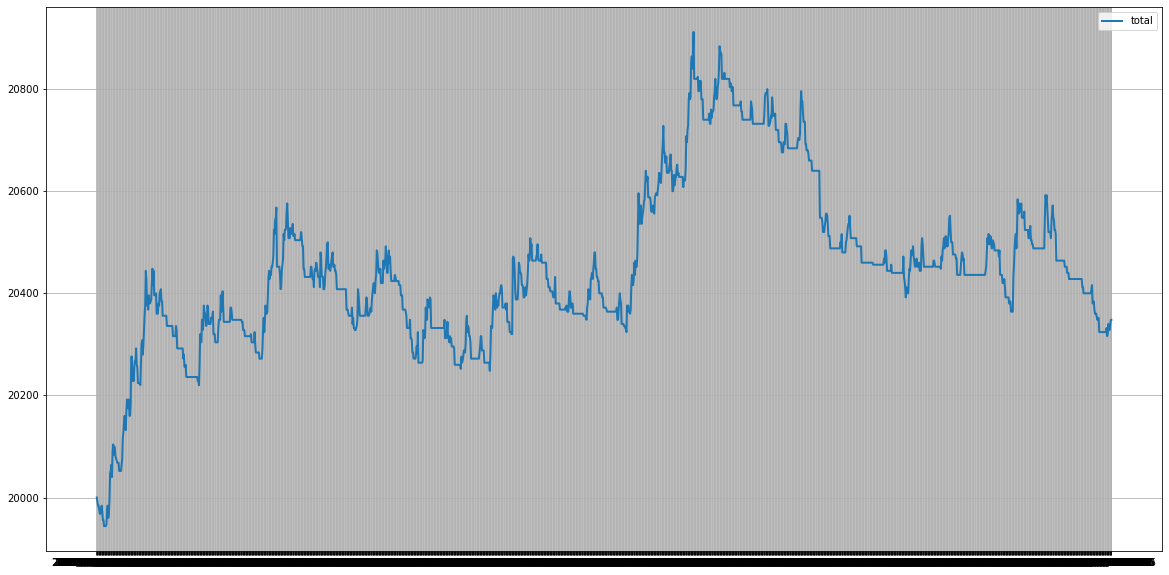

In [73]:
plt.figure(figsize=(20,10))
# 用实线画股价
# plt.plot(rb_df['close'],lw=2,label='price')
# plt.plot(rb_df['ma0'],lw=2,ls='--',label='ma0')
# plt.plot(rb_df['ma1'],lw=2,ls='-.',label='ma1')
# plt.scatter(portfolio.loc[strategy.order==1].index,
#             zgpa['close'][strategy.order==1],
#            marker='^',s=80,color='g',label='buy')
# plt.scatter(strategy.loc[strategy.order==-1].index,
#             zgpa['close'][strategy.order==1],
#            marker='v',s=80,color='g',label='sell')
plt.plot(portfolio['total'],lw=2,label='total')
# plt.plot(portfolio['cash'], lw=2, ls='--',label='cash')
plt.legend()
plt.grid()
plt.show()

In [58]:
strategy = pd.DataFrame(rb_df.index)
strategy['order'] = 0

In [47]:
position=0
for k in range(len(rb_df)):
    if

0       NaN
1       0.0
2       0.0
3       1.0
4      -1.0
       ... 
1675    0.0
1676    0.0
1677    0.0
1678    0.0
1679    0.0
Name: order, Length: 1680, dtype: float64

In [ ]:
turtle['orders'] = 0 
position = 0
for k in range(len(turtle)):
    if turtle.buy[k] and position == 0:
        turtle.orders.values[k] = 1
        position = 1
    elif turtle.sell[k] and position > 0:
        turtle.orders.values[k] = -1
        position =0
turtle.tail(15)